# Final - _Due Thursday, October 20_
---
## Note: this is the final. It is _not_ a paired programming assignment. **You must complete this lab _on your own_**. 
---
### We'll be exploring the "Airplane Crashes Since 1908" dataset from [Kaggle](http://www.kaggle.com).
### Full history of airplane crashes throughout the world, from 1908-present.
The dataset was downloaded from https://www.kaggle.com/saurograndi/airplane-crashes-since-1908. 

After loading and cleaning the data:

+ **Hypothesis Testing** 
    
+ **Linear Regression**
    
+ **Time Series**

***
## Setup & clean the data
### First, load the packages that will be used in this notebook.

In [1]:
%pylab inline

import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.diagnostic import het_breushpagan
from statsmodels.graphics.correlation import plot_corr
from statsmodels.graphics.regressionplots import plot_leverage_resid2
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.genmod.families import family

from sqlalchemy import create_engine
from scipy import stats

random.seed(1234)
sns.set(font_scale=1.5)

Populating the interactive namespace from numpy and matplotlib


### Next, load the csv file into a DataFrame and look at the first few lines.

In [2]:
df = pd.read_csv('Airplane_Crashes_and_Fatalities_Since_1908.csv')
df.head()

,Date,Time,Location,Operator,Flight #,Route,Type,Registration,cn/In,Aboard,Fatalities,Ground,Summary
0,09/17/1908,17:18,"Fort Myer, Virginia",Military - U.S. Army,NaN,Demonstration,Wright Flyer III,NaN,1,2.0,1.0,0.0,"During a demonstration flight, a U.S. Army fly..."
1,07/12/1912,06:30,"AtlantiCity, New Jersey",Military - U.S. Navy,NaN,Test flight,Dirigible,NaN,NaN,5.0,5.0,0.0,First U.S. dirigible Akron exploded just offsh...
2,08/06/1913,NaN,"Victoria, British Columbia, Canada",Private,-,NaN,Curtiss seaplane,NaN,NaN,1.0,1.0,0.0,The first fatal airplane accident in Canada oc...
3,09/09/1913,18:30,Over the North Sea,Military - German Navy,NaN,NaN,Zeppelin L-1 (airship),NaN,NaN,20.0,14.0,0.0,The airship flew into a thunderstorm and encou...
4,10/17/1913,10:30,"Near Johannisthal, Germany",Military - German Navy,NaN,NaN,Zeppelin L-2 (airship),NaN,NaN,30.0,30.0,0.0,Hydrogen gas which was being vented was sucked...


Here are the variable descriptions (not available in Kaggle website, but from my own understanding of the data):

|Variable|Description|
|:-:|:--|
|**Date**|Date of the accident|
|**Time**|Time of the accident|
|**Location**|Where the accident happened|
|**Operator**|The name of the airline having the accident|
|**Flight#**|The airline flight number|
|**Route**|The location where the flight was bounded|
|**Type**|The type of aircraft that had the accident|
|**Registration**|An alphanumeric string to identify the aircraft|
|**cn/ln**|Serial number of the aircraft|
|**Aboard**|Number of people that was on the aircraft|
|**Fatalities**|The number of fatalities of the total people aboard|
|**Ground**|The distance from the ground when the fatality happened|
|**Summary**|A free text field that summarizes and describes the accident|

Note that the field "Registration" should be unique (per NAA regulations), but after running a SQL query, we found duplicated records.

We can also modify the column names to get rid of periods and spaces. The column names should also be lowercased for use with SQLite.

In [3]:
# Lowercase and replace periods & spaces in the column names
new_names = []

for col in df.columns:
    new_names.append(col.replace('.', '', len(col)).replace(' ', '', len(col)).lower())

df.columns = new_names

print(df.columns)

Index(['date', 'time', 'location', 'operator', 'flight#', 'route', 'type',
       'registration', 'cn/in', 'aboard', 'fatalities', 'ground', 'summary'],
      dtype='object')


In [4]:
df.count()

date            5268
time            3049
location        5248
operator        5250
flight#         1069
route           3562
type            5241
registration    4933
cn/in           4040
aboard          5246
fatalities      5256
ground          5246
summary         4878
dtype: int64

In [5]:
df = df.dropna(axis=0)

In [6]:
df.count()

date            944
time            944
location        944
operator        944
flight#         944
route           944
type            944
registration    944
cn/in           944
aboard          944
fatalities      944
ground          944
summary         944
dtype: int64

We can see that the above numeric variables (aboard, fatalities, ground) have missing data (per NaN values), so will create a new dataset without missing values.

In [7]:
# Date column is not datetime format, so we format it appropiately.
df['date'] = pd.to_datetime(df['date'])

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 944 entries, 208 to 5265
Data columns (total 13 columns):
date            944 non-null datetime64[ns]
time            944 non-null object
location        944 non-null object
operator        944 non-null object
flight#         944 non-null object
route           944 non-null object
type            944 non-null object
registration    944 non-null object
cn/in           944 non-null object
aboard          944 non-null float64
fatalities      944 non-null float64
ground          944 non-null float64
summary         944 non-null object
dtypes: datetime64[ns](1), float64(3), object(9)
memory usage: 103.2+ KB


In [9]:
df.insert(1,'year', df['date'].apply(lambda x: x.year))
df.insert(2,'month', df['date'].apply(lambda x: x.month))
df.insert(3,'dayofweek', df['date'].apply(lambda x: x.dayofweek))
df.insert(4,'hour', df['time'].str[:2])

In [10]:
df.head()

,date,year,month,dayofweek,hour,time,location,operator,flight#,route,type,registration,cn/in,aboard,fatalities,ground,summary
208,1930-01-19,1930,1,6,18,18:23,"Oceanside, California",Maddux Airlines,7,"Aqua Caliente, Mexico - Los Angeles",Ford 5-AT-C Tri Motor,NC9689,5-AT-046,16.0,16.0,0.0,"While en route to Los Angeles, the pilot, flyi..."
236,1931-03-31,1931,3,1,10,10:45,"Bazaar, Kansas",Trans Continental and Western Air,599,Kansas City - Wichita - Los Angeles,Fokker F10A Trimotor,NC-999,1063,8.0,8.0,0.0,"Shortly after taking off from Kansas City, one..."
334,1934-08-31,1934,8,4,23,23:42,"Amazonia, Missouri",Rapid Air Transport,6,Omaha - St. Joseph,Stinson SM-6000B,NC10809,5004,5.0,5.0,0.0,The plane crashed about 11 miles from St. Jose...
354,1935-05-06,1935,5,0,03,03:30,"Atlanta, Missouri",Trans Continental and Western Air,6,Los Angeles - Albuquerque - Kanasas City - Wa...,Douglas DC-2-112,NC13785,1295,14.0,5.0,0.0,The plane crashed while en route from Albuquer...
365,1935-08-14,1935,8,2,23,23:45,"Near Gilmer, Texas",Delta Air Lines,4,Dallas - Atlanta,Stinson Model A,NC14599,9103,4.0,4.0,0.0,Crashed 3 miles south of Gilmer. The outboard ...


## Hypothesis Testing

We will be using a significance level of 0.05

In [11]:
antonov_df = df[df['type'].str[:6] == ('Antono')]

In [12]:
airbus_df = df[df['type'].str[:6] == ('Airbus')]

In [13]:
boeing_df = df[df['type'].str[:6] == ('Boeing')]

#### The aircraft manufacturer Antonov claims the fatalities in their airplanes is less than 22 passengers.

We want to know if the number of fatalities is more than 22.

$H_0: \mu <= 22$

$H_a: \mu > 22$

$t_{stat} = \frac{\bar{X} - \mu_0}{s/ \sqrt{n}} $

In [14]:
t_stat_antonov = (antonov_df.fatalities.mean() - 22)/(antonov_df.fatalities.std()/len(antonov_df)**0.5)
t_stat_antonov

1.1952265304572087

In [15]:
p_value_antonov = stats.t(len(antonov_df)-1).cdf(t_stat_antonov)
p_value_antonov

0.87472304369831599

The p-value is more than 0.05, therefore, we fail to reject the null hypothesis. There's no enough evidence to support that the fatalities in an aircraft manufactured by Antonov is more than 22.

A Type I error would be to claim that the Antonov aircraft have more than 22 fatalities, when they have less.

A Type II error would be to claim that the Antonov aircraft have less than 22 fatalities, when they have more.

#### The aircraft manufacturer Airbus claims the fatalities in their airplanes is less than 20%.

We want to know if the number of fatalities is more than 20%.

$H_0: p <= 20$%

$H_a: p > 20$%

In [16]:
percent_fatalities = airbus_df.fatalities/airbus_df.aboard

In [17]:
z_stat_airbus = (percent_fatalities.mean() - 0.20)/((0.20 * (1 - 0.20)/len(percent_fatalities)))**0.5
z_stat_airbus

5.672359779080775

In [18]:
p_value_airbus = stats.norm.cdf(z_stat_airbus)
p_value_airbus

0.99999999295781039

The p-value is more than 0.05, therefore, we fail to reject the null hypothesis. There's no enough evidence to support that the percentage of fatalities in an aircraft manufactured by Airbus is more than 20%.

A Type I error would be to claim that the Airbus aircraft have more than 20% fatalities, when they have less.

A Type II error would be to claim that the Airbys aircraft have less than 20% fatalities, when they have more.

In [19]:
boeing_average_fatalities = boeing_df.fatalities.mean()
boeing_std_deviation_fatalities = boeing_df.fatalities.std()
boeing_sample = len(boeing_df)
boeing_average_fatalities, boeing_std_deviation_fatalities, boeing_sample

(79.56613756613757, 83.09051790899629, 189)

#### Boeing claims that the average fatalities for their airplanes is more than 60. To test the claim, a random sample of 189 flights showed an average of 75.57 fatalities, with a standard deviation s of 89.09.  The FFA claims that average fatalities for Boeing is 70, what is the power of the test?

In [20]:
print("The power of the test is:",stats.t(189-1).cdf((boeing_average_fatalities - 70)/(boeing_std_deviation_fatalities /189**0.5)))

The power of the test is: 0.942421919705


So probability of rejecting the null hypothesis $H_0$ when the alternative hypothesis $H_a$ is true is 94%.

#### There's no difference in the number of fatalities for aircrafts Airbus and Boeing.

We want to know if they are different.

$H_0: \mu_1 = \mu_2 \text{ or } \mu_1 - \mu_2 = 0$  

$H_a: \mu_1 \neq \mu_2 \text{ or } \mu_1 - \mu_2 \neq 0$

In [21]:
stats.ttest_ind_from_stats(airbus_df.fatalities.mean(),airbus_df.fatalities.std(),airbus_df.fatalities.count(),boeing_df.fatalities.mean(),boeing_df.fatalities.std(),boeing_df.fatalities.count())

Ttest_indResult(statistic=1.3264713131542651, pvalue=0.18608438449452927)

The p-value is more than 0.05, therefore we reject the null hypothesis. There's no enough evidence to conclude that the average fatalities for Airbus and Boeing is different.

### Are the fatalities independent of aircraft type Antonov, Airbus and Boeing?

$H_0$: fatalities are independent from aircraft type (Antonov, Airbus or Boeing).

$H_a$: fatalities are dependent from aircraft type (Antonov, Airbus or Boeing).

In [22]:
accidents_df = pd.DataFrame(index=['Fatalities'], columns=['Antonov','Airbus','Boeing'])
accidents_df.head()

,Antonov,Airbus,Boeing
Fatalities,NaN,NaN,NaN


In [23]:
accidents_df['Antonov'] = [antonov_df.fatalities.sum()]
accidents_df['Airbus'] = [airbus_df.fatalities.sum()]
accidents_df['Boeing'] = [boeing_df.fatalities.sum()]

In [24]:
accidents_df

,Antonov,Airbus,Boeing
Fatalities,469.0,2958.0,15038.0


In [25]:
# In order to pass the dataframe data into stats.chisquare, IT NEEDS TO BE CONVERTED FROM PANDAS
# DATAFRAME INTO NUMPY ARRAY OR LIST.
fatalities_total_array = np.asarray(accidents_df.ix[0,:])
fatalities_total_array

array([   469.,   2958.,  15038.])

In [26]:
expected_fatalities = [accidents_df.sum().sum()/3]*3
expected_fatalities

[6155.0, 6155.0, 6155.0]

In [27]:
stats.chisquare(fatalities_total_array, expected_fatalities)

Power_divergenceResult(statistic=19733.402761982128, pvalue=0.0)

The p-value is less than 0.05, therefore we reject the null hypothesis that aircraft fatalities is independent from the aircraft type (Antonov, Airbus, Boeing).

## Linear Regression

The histogram below is to state that the nature of our data doesn't follow the criteria to fit linear regression as it is extremely right skewed. Our data seems to follow a Poisson distribution (count of fatalities), as we explained in the Midterm, Part 2. A centered distibution would be ideal to fit a linear regression model.

However, we will discuss and examine the results of the models we will be building.

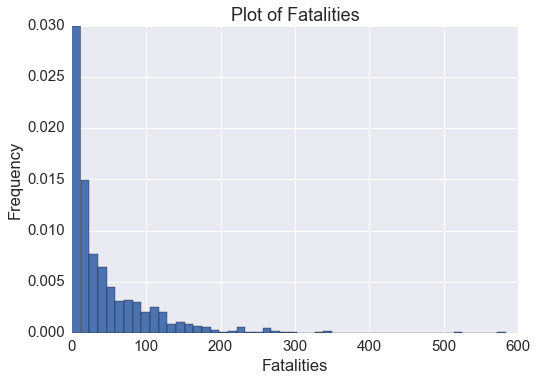

In [28]:
df.hist('fatalities', bins=50, normed=True)
title('Plot of Fatalities')
ylabel('Frequency')
xlabel('Fatalities');

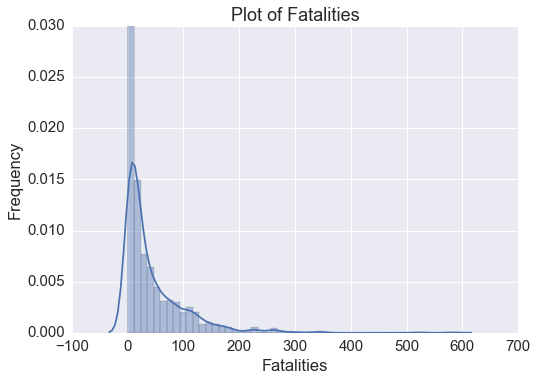

In [29]:
sns.distplot(df.fatalities,bins=50,hist=True)
title('Plot of Fatalities')
ylabel('Frequency')
xlabel('Fatalities');

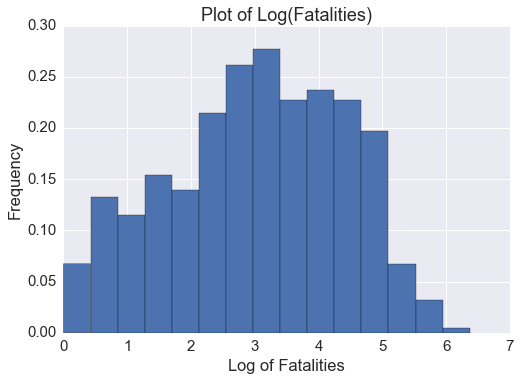

In [30]:
# We have to add 1 to the log as we have instances where fatalities = 0.
log_fatalities = log(df['fatalities'] + 1)
plt.hist(log_fatalities,bins=15, normed=True)
title('Plot of Log(Fatalities)')
ylabel('Frequency')
xlabel('Log of Fatalities');

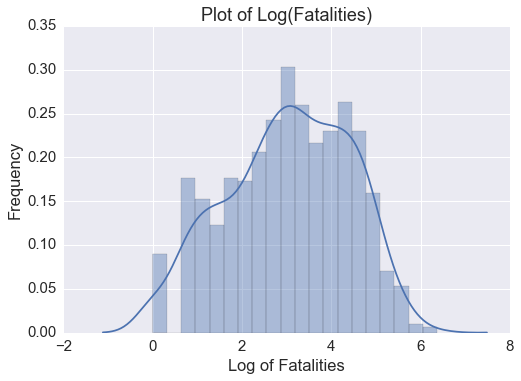

In [31]:
sns.distplot(log(df.fatalities+1),bins=20,hist=True)
title('Plot of Log(Fatalities)')
ylabel('Frequency')
xlabel('Log of Fatalities');

### Simple Regression

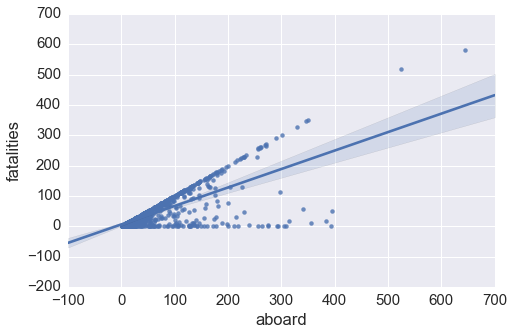

In [32]:
sns.lmplot(x='aboard', y='fatalities', data=df, aspect=1.5);

We can see some nonlinearity evident in the above plot.

In [33]:
X_one = df.aboard
X_one = sm.add_constant(X_one)
y_one = df.fatalities

model_one = sm.OLS(y_one, X_one)
results_one = model_one.fit()
results_one.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             fatalities   R-squared:                       0.540
Model:                            OLS   Adj. R-squared:                  0.539
Method:                 Least Squares   F-statistic:                     1104.
Date:                Sun, 16 Oct 2016   Prob (F-statistic):          7.22e-161
Time:                        11:11:01   Log-Likelihood:                -4825.7
No. Observations:                 944   AIC:                             9655.
Df Residuals:                     942   BIC:                             9665.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.0171      1.747      3.443      0.001       2.588       9.446
aboard         0.6094      0.018     33.231      0.000       0.573       0.645
==============================================================================
Omnibus:                      362.672   Durbin-Watson:                   1.980
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3339.143
Skew:                          -1.492   Prob(JB):                         0.00
Kurtosis:                      11.717   Cond. No.                         127.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

$\hat{fatalities} = 4.3750 + aboard * 0.5989$

#### Interpreting $R^2$:

The percentage of the variation in y (fatalities) can be explained by the corresponding variation in X (passengers aboard) and the least-squares line is 54%, and the unexplained percentage of variation is 100% – 54% = 46%.

#### Interpreting the model:

For every unit of increase of passengers aboard, fatalities increase by 0.6094.

#### Hypothesis testing:

Using a significance level of 0.05.

$H_0: \beta_1 = 0$

$H_a: \beta_1 \neq 0$

The F-statistic of the model is 1104 and the p-value is 7.22e-161. 

Since the p-value is less than 0.05, so reject the null hypothesis and conclude that the coefficient of passengers aboard is significant.

#### Making a prediction of fatalities for all aircrafts with 2,000 passengers aboard:

In [34]:
results_one.predict([1, 2000])

array([ 1224.85578457])

#### The confidence interval for the above prediction is:

In [35]:
x = df.aboard
se = sqrt(results_one.mse_resid)
b0, b1 = results_one.params

x_new = 2000

def confidence_se(s_e, x, x_new):
    mean_x = x.mean()
    var_x = x.var()
    n = len(x)
    return s_e * (1/n + (x_new - mean_x)**2 / ((n - 1) * var_x))**0.5

sign = array([-1., 1.])
b0 + b1 * x_new + sign * 1.96 * confidence_se(se, x, x_new)

array([ 1155.19034085,  1294.5212283 ])

#### The prediction interval for a particular aircraft with 2,000 passengers aboard:

In [36]:
def prediction_se(s_e, x, x_new):
    mean_x = x.mean()
    var_x = x.var()
    n = len(x)
    return s_e * (1 + 1/n + (x_new - mean_x)**2 / ((n - 1) * var_x))**0.5

b0 + b1 * x_new + sign * 1.96 * prediction_se(se, x, x_new)

array([ 1119.67023424,  1330.0413349 ])

For both the given population of all aircrafts with passengers aboard of 2,000, the mean is the same as one aircraft with 2,000 passengers aboard. HOWEVER, the variance for the given population of all aircrafts with passengers aboard of 2,000 is $\sigma^2/n$, when the variance for the one aircraft with 2,000 passengers aboard is $\sigma^2$, which is more than the variance for the given population of all aircrafts with passengers aboard of 2,000. THEREFORE, the confidence interval for the given population of all aircrafts with passengers aboard of 2,000 is smaller than the prediction interval for the one aircraft with 2,000 passengers aboard.

#### Another way of constructing the linear model:

In [37]:
correlation = corrcoef(df.aboard,df.fatalities)

In [38]:
b_1 = correlation[0][1] * (df.fatalities.std()/df.aboard.std())
b_1

0.60941935321163954

In [39]:
b_0 = df.fatalities.mean() - b_1 * df.aboard.mean()
b_0

6.0170781508552764

$\hat{fatalities} = b_0 + b_1 * aboard$

#### Checking residuals

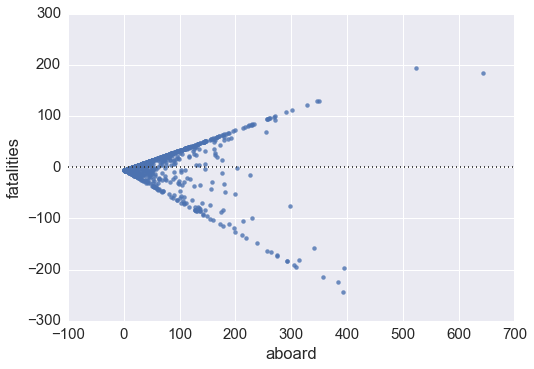

In [40]:
sns.residplot('aboard', 'fatalities', df);

We can see the relationship between the residuals and the predictive variable `aboard`. The non-linearity is more evident here.

#### Test for non-Normality

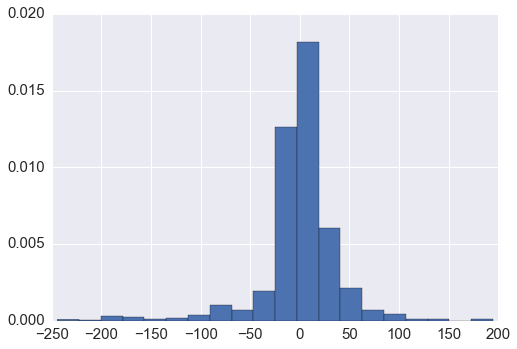

In [41]:
# Histogram of residuals.
res_one = results_one.resid
hist(res_one, bins = 20, normed=True);

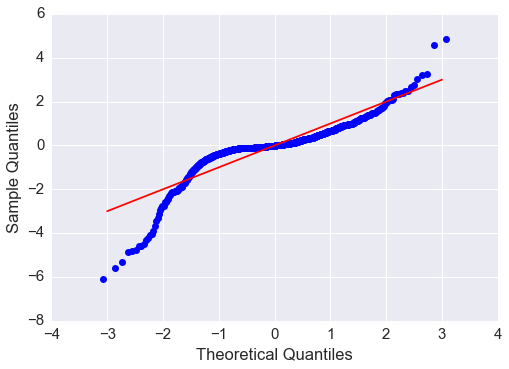

In [42]:
## QQ plot of residuals.
sres_one = results_one.resid_pearson
qqplot(sres_one)
q = linspace(-3, 3)
plot(q, q, color='r');

Non-normality visually confirmed using both plots.

Numerical method for Normality.

$H_0$ : data is Normally distributed.

$H_a$: data is not Normally distributed.

A small p-value indicates violation of the Normality assumption.

From the OLS model we get:

Jarque-Bera (JB): 3339.143

Prob(JB): 0.00

The p-value for the Normality test is 0.00, therefore, we reject the null hypothesis and conclude that data is not Normally distributed.

#### Test for heteroskedasticity.

Numerical tests for heteroskedasticity.

$H_0$: constant variance.

$H_1$: non-constant variance.

A small p-value gives evidence for non-constant variance, therefore we reject the null hypothesis.

In [43]:
het_breushpagan(results_one.resid, results_one.model.exog) # the second output gives the p-value of the test

(547.41601561540119,
 4.5931867731392e-121,
 1300.2690653529414,
 1.3704099389390326e-179)

The p-value of 4.5931867731392e-121 is less than 0.05, therefore we reject the null hypothesis of and conclude that data shows heteroskedasticity.

#### We will transform/log our dependent/predictive variable y (fatalities) as attempt to fix non-linearity of residuals, non-Normality and Heteroskedasticity.

In [44]:
# Since we have some instances of 0 fatalities and to avoid log(0), we will add 1 to all fatalities.
log_y = np.log(y_one + 1)
model_log = sm.OLS(log_y, X_one)
results_log = model_log.fit()

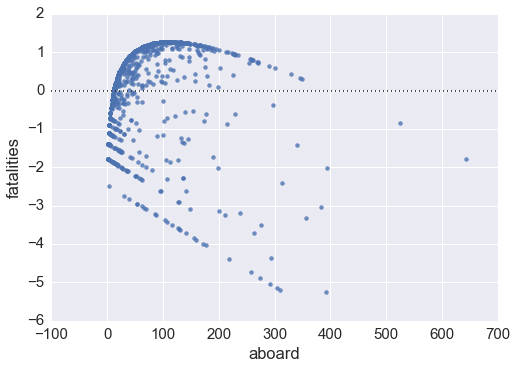

In [45]:
sns.residplot(X_one.aboard, log_y, df);

The log transformation didn't produce any notable effect. We still see signs of relationship between residuals and predictor variable `aboard`.

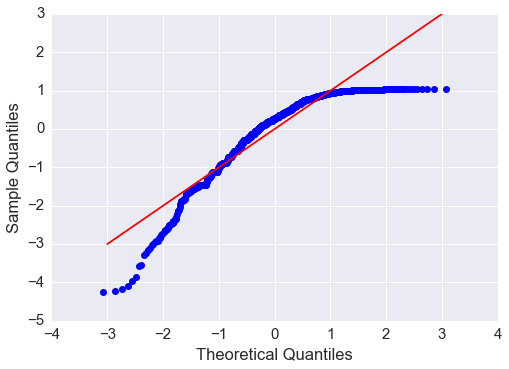

In [46]:
sres_one = results_log.resid_pearson
qqplot(sres_one)
q = linspace(-3, 3)
plot(q, q, color='r');

Non-normality has become worse. We will not bother testing for heteroskedasticity.

Let's take a look at outliers:

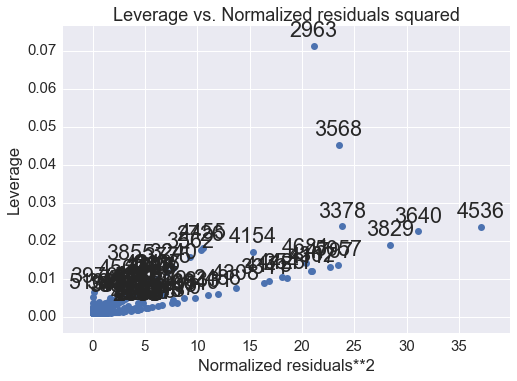

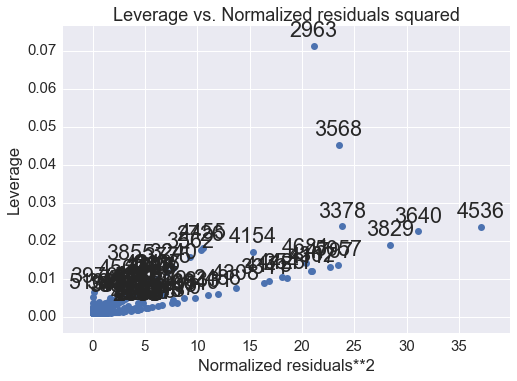

In [47]:
plot_leverage_resid2(results_one)

It's difficult to see all the ID's of outliers, but we will removing the ones easy to spot:

In [48]:
df_new = df[(df.index != 2963) & (df.index != 3568) & (df.index != 3378) & (df.index != 3829) & (df.index != 3640) & (df.index != 4536) & (df.index != 4154)]

To check if we have removed data points:

In [49]:
len(df_new), len(df)

(937, 944)

We run a new model without some outliers:

In [50]:
X_new = df_new.aboard
X_new = sm.add_constant(X_new)
y_new = df_new.fatalities

model_new = sm.OLS(y_new, X_new)
results_new = model_new.fit()
results_new.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             fatalities   R-squared:                       0.560
Model:                            OLS   Adj. R-squared:                  0.559
Method:                 Least Squares   F-statistic:                     1189.
Date:                Sun, 16 Oct 2016   Prob (F-statistic):          9.94e-169
Time:                        11:11:03   Log-Likelihood:                -4692.2
No. Observations:                 937   AIC:                             9388.
Df Residuals:                     935   BIC:                             9398.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.6573      1.634      2.850      0.004       1.450       7.865
aboard         0.6435      0.019     34.475      0.000       0.607       0.680
==============================================================================
Omnibus:                      396.103   Durbin-Watson:                   1.928
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3011.911
Skew:                          -1.749   Prob(JB):                         0.00
Kurtosis:                      11.057   Cond. No.                         121.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

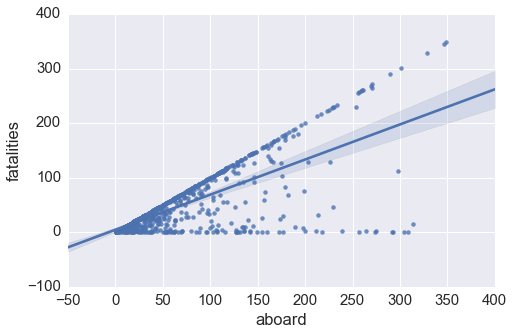

In [51]:
sns.lmplot('aboard', 'fatalities', df_new, aspect=1.5);

No improvement.

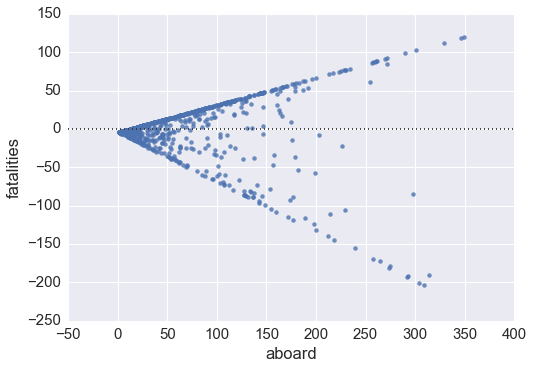

In [52]:
sns.residplot('aboard', 'fatalities', df_new);

The $R^2$, F-statistic a p-value associated of the new model have improved, but the residuals have not, so will stop analysis here as we still have relationship between residuals and predictor variable `aboard`, non-Normality and heteroskedasticity.

#### We will have another attempt to transform a variable, in this case the predictor one by $\sqrt X$:

In [53]:
X_sq = (df.aboard)**0.05
X_sq = sm.add_constant(X_sq)
y_sq = df.fatalities

model_sq = sm.OLS(y_sq, X_sq)
results_sq = model_sq.fit()
results_sq.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             fatalities   R-squared:                       0.416
Model:                            OLS   Adj. R-squared:                  0.415
Method:                 Least Squares   F-statistic:                     669.8
Date:                Sun, 16 Oct 2016   Prob (F-statistic):          5.52e-112
Time:                        11:11:04   Log-Likelihood:                -4938.3
No. Observations:                 944   AIC:                             9881.
Df Residuals:                     942   BIC:                             9890.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -572.1141     23.871    -23.967      0.000    -618.961    -525.267
aboard       516.4473     19.955     25.880      0.000     477.285     555.609
==============================================================================
Omnibus:                      564.589   Durbin-Watson:                   1.917
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            13055.882
Skew:                           2.281   Prob(JB):                         0.00
Kurtosis:                      20.639   Cond. No.                         32.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Let's check the residuals:

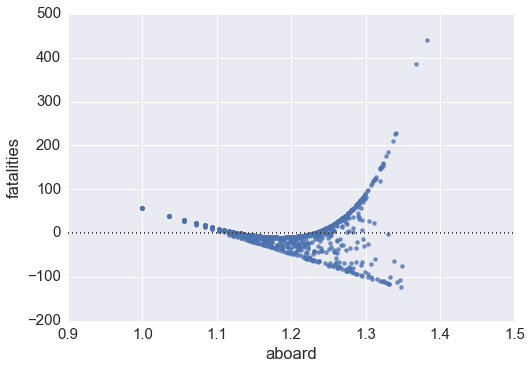

In [54]:
sns.residplot(X_sq.aboard, y_sq, df);

Since there's a strong relationship between the residuals and the predictor variable, we abandon further analysis.

### Multiple Regression

We start multiple regression, focusing only on numerical variables first.

Let's check if they are correlated:

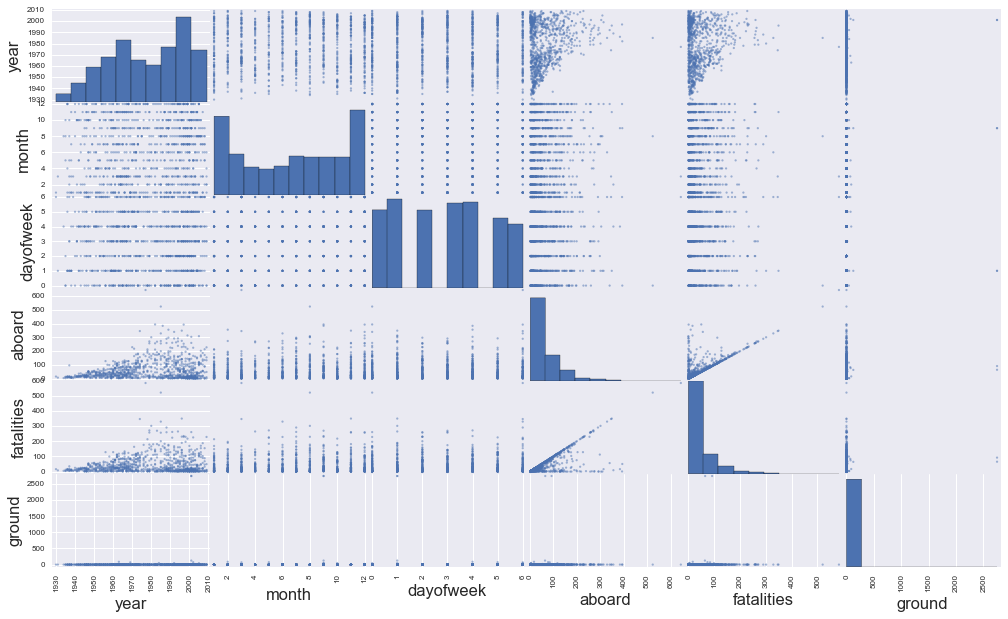

In [55]:
pd.scatter_matrix(df, figsize=(17, 10), edgecolor='none', alpha=0.5);

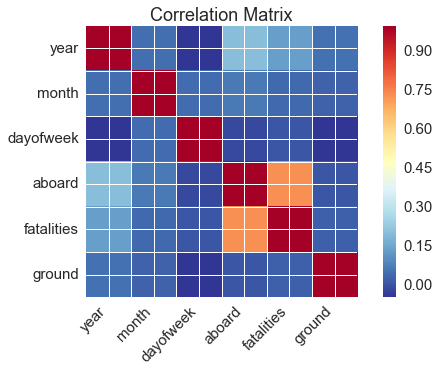

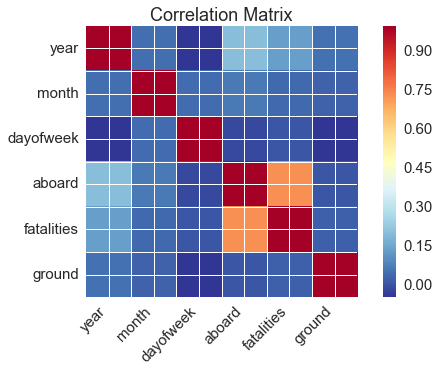

In [56]:
numerics_only = df.select_dtypes(['int64', 'float64'])
sm.graphics.plot_corr(numerics_only.corr(), xnames=numerics_only.columns.tolist())

In [57]:
numerics_only.corr()

,year,month,dayofweek,aboard,fatalities,ground
year,1.000000,0.052456,-0.041120,0.207855,0.142569,0.055780
month,0.052456,1.000000,0.047339,0.073920,0.043106,0.030059
dayofweek,-0.041120,0.047339,1.000000,-0.009206,0.011575,-0.043698
aboard,0.207855,0.073920,-0.009206,1.000000,0.734616,0.010455
fatalities,0.142569,0.043106,0.011575,0.734616,1.000000,0.028327
ground,0.055780,0.030059,-0.043698,0.010455,0.028327,1.000000


We don't see colinearity among independent variables. Let's build a model:

In [58]:
X_multi = df[['aboard','ground','year','dayofweek']]
X_multi = sm.add_constant(X_multi)
y_multi = df['fatalities']

model_multi = sm.OLS(y_multi, X_multi)
results_multi = model_multi.fit()
results_multi.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             fatalities   R-squared:                       0.541
Model:                            OLS   Adj. R-squared:                  0.539
Method:                 Least Squares   F-statistic:                     276.2
Date:                Sun, 16 Oct 2016   Prob (F-statistic):          6.55e-157
Time:                        11:11:08   Log-Likelihood:                -4824.7
No. Observations:                 944   AIC:                             9659.
Df Residuals:                     939   BIC:                             9684.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         68.7752    132.406      0.519      0.604    -191.071     328.621
aboard         0.6113      0.019     32.585      0.000       0.574       0.648
ground         0.0103      0.010      0.995      0.320      -0.010       0.031
year          -0.0327      0.067     -0.487      0.626      -0.164       0.099
dayofweek      0.5765      0.677      0.852      0.395      -0.752       1.905
==============================================================================
Omnibus:                      362.734   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3355.493
Skew:                          -1.491   Prob(JB):                         0.00
Kurtosis:                      11.742   Cond. No.                     2.00e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large,  2e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The regression equation is:

$\hat{fatalities} = 68.7752 + aboard * 0.6113 + ground * 0.0103 - year * 0.0327 + dayofweek * 0.5765$

#### Interpretation of $R^2$ and overall F test:

The adjusted $R^2$ (0.539), F-statistic (276.2) and associated p-value (6.55e-157) are good:

We have extremely strong evidence to conclude that the at least one of the variables in the model is useful for predicting `fatalities`.

However, we have some some predictor variables with high p-values:

year: 0.626
dayofweek: 0.395
ground: 0.320

Let's proceed with a backward stepwise regression by eliminating first `year`.

In [59]:
X_multi = df[['aboard','ground','dayofweek']]
X_multi = sm.add_constant(X_multi)
y_multi = df['fatalities']

model_multi = sm.OLS(y_multi, X_multi)
results_multi = model_multi.fit()
results_multi.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             fatalities   R-squared:                       0.540
Model:                            OLS   Adj. R-squared:                  0.539
Method:                 Least Squares   F-statistic:                     368.5
Date:                Sun, 16 Oct 2016   Prob (F-statistic):          3.54e-158
Time:                        11:11:08   Log-Likelihood:                -4824.9
No. Observations:                 944   AIC:                             9658.
Df Residuals:                     940   BIC:                             9677.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.2654      2.620      1.628      0.104      -0.876       9.407
aboard         0.6094      0.018     33.219      0.000       0.573       0.645
ground         0.0100      0.010      0.971      0.332      -0.010       0.030
dayofweek      0.5890      0.676      0.871      0.384      -0.738       1.916
==============================================================================
Omnibus:                      362.565   Durbin-Watson:                   1.980
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3362.464
Skew:                          -1.489   Prob(JB):                         0.00
Kurtosis:                      11.753   Cond. No.                         259.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Adjusted $R^2$ is the same, but the F-statistic and associated p-value have improved, so this is a better model.

Let's remove now `dayofweek` due to it's high p-value (0.384):

In [60]:
X_multi = df[['aboard','ground']]
X_multi = sm.add_constant(X_multi)
y_multi = df['fatalities']

model_multi = sm.OLS(y_multi, X_multi)
results_multi = model_multi.fit()
results_multi.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             fatalities   R-squared:                       0.540
Model:                            OLS   Adj. R-squared:                  0.539
Method:                 Least Squares   F-statistic:                     552.5
Date:                Sun, 16 Oct 2016   Prob (F-statistic):          1.95e-159
Time:                        11:11:08   Log-Likelihood:                -4825.2
No. Observations:                 944   AIC:                             9656.
Df Residuals:                     941   BIC:                             9671.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.9645      1.748      3.411      0.001       2.533       9.396
aboard         0.6092      0.018     33.217      0.000       0.573       0.645
ground         0.0097      0.010      0.934      0.351      -0.011       0.030
==============================================================================
Omnibus:                      362.021   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3341.682
Skew:                          -1.488   Prob(JB):                         0.00
Kurtosis:                      11.724   Cond. No.                         170.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Again, the model has improved by looking at the new F-statistic and it's p-value, but `ground` it's irrelevant due to it's p-value higher than 0.05.

Finally, let's try a formula to model interactions:

In [61]:
formula = 'fatalities ~ aboard * ground + aboard + ground'

In [62]:
model_formula = smf.ols(formula = formula, data = df)
results_formula = model_formula.fit()
results_formula.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             fatalities   R-squared:                       0.540
Model:                            OLS   Adj. R-squared:                  0.539
Method:                 Least Squares   F-statistic:                     368.1
Date:                Sun, 16 Oct 2016   Prob (F-statistic):          4.82e-158
Time:                        11:11:08   Log-Likelihood:                -4825.2
No. Observations:                 944   AIC:                             9658.
Df Residuals:                     940   BIC:                             9678.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         5.9790      1.750      3.417      0.001       2.545       9.413
aboard            0.6090      0.018     33.178      0.000       0.573       0.645
ground           -0.0126      0.060     -0.209      0.834      -0.131       0.106
aboard:ground     0.0003      0.001      0.375      0.708      -0.001       0.002
==============================================================================
Omnibus:                      361.829   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3340.634
Skew:                          -1.487   Prob(JB):                         0.00
Kurtosis:                      11.723   Cond. No.                     1.35e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.35e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

We can see that even though the F-statistic and p-value are relevant, the p-values of the interaction is higher than 0.05, so we fail to reject the null hypothesis and conclude that the new interaction variable is not significant.

#### Trying to fit a multiple regression model on a categorical variables.

We will binarize the categorical variables.

WARNING: since our dataframe has many different values for the categorical variables, we will dropping some columns as we would creating hundreds of them. For example:

In [63]:
len(df.summary.unique()), len(df.location.unique()), len(df['flight#'].unique()), len(df.type.unique())

(944, 850, 667, 620)

In [64]:
df_binarized = df.copy()
df_binarized = df_binarized.drop(['summary','time','hour','flight#','registration','cn/in','type','location'], axis=1)

In [65]:
df_binarized = pd.get_dummies(df_binarized)

In [66]:
df_binarized.columns

Index(['date', 'year', 'month', 'dayofweek', 'aboard', 'fatalities', 'ground',
       'operator_AB Aerotransport', 'operator_ACES Colombia',
       'operator_ADC Airlines',
       ...
       'route_Winnipeg - Thunder Bay, Ontario', 'route_Xian - Guangzhou',
       'route_Yakima - Pasco', 'route_Yekaterinburg - Irkutsk - Vladivostok',
       'route_Yerevan, Armenia - Sochi, Russia', 'route_Yinchuan - Beijing',
       'route_Yushno - Khabarovk', 'route_Zurich - Geneva',
       'route_Zurich - Tel Aviv', 'route_Zürich - Dresden'],
      dtype='object', length=1445)

We need to remove one column per dummy variable created.

In [67]:
df_binarized.drop(['route_Zürich - Dresden','operator_Delta Air Lines'], axis=1)

,date,year,month,dayofweek,aboard,fatalities,ground,operator_AB Aerotransport,operator_ACES Colombia,operator_ADC Airlines,...,route_Winnipeg - Sandy Lake,"route_Winnipeg - Thunder Bay, Ontario",route_Xian - Guangzhou,route_Yakima - Pasco,route_Yekaterinburg - Irkutsk - Vladivostok,"route_Yerevan, Armenia - Sochi, Russia",route_Yinchuan - Beijing,route_Yushno - Khabarovk,route_Zurich - Geneva,route_Zurich - Tel Aviv
208,1930-01-19,1930,1,6,16.0,16.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
236,1931-03-31,1931,3,1,8.0,8.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
334,1934-08-31,1934,8,4,5.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
354,1935-05-06,1935,5,0,14.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
365,1935-08-14,1935,8,2,4.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
370,1935-10-07,1935,10,0,12.0,12.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
382,1936-01-14,1936,1,1,17.0,17.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
390,1936-04-07,1936,4,1,15.0,13.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
419,1936-12-15,1936,12,1,7.0,7.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
421,1936-12-19,1936,12,5,14.0,14.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [68]:
# Taking out also date as it's of datetime64 type and will cause the regression to fail as it expect only numeric values.
indep_variables = df_binarized.columns.drop(['date','fatalities'])

In [69]:
X_list = []
for i in range(len(indep_variables)):
    X_list.append(indep_variables[i])
X_list

['year',
 'month',
 'dayofweek',
 'aboard',
 'ground',
 'operator_AB Aerotransport',
 'operator_ACES Colombia',
 'operator_ADC Airlines',
 'operator_AECA Cargo',
 'operator_ANT Air Taxi',
 'operator_AREA',
 'operator_ATI',
 'operator_AV Air / American Eagle',
 'operator_AVIANCA',
 'operator_Aaxico Airlines',
 'operator_Action Air Express Inc. - Air Taxi',
 'operator_Adam Air',
 'operator_Aer Lingus',
 'operator_Aero Ferinco Charter',
 'operator_Aerocaribe',
 'operator_Aeroflot',
 'operator_Aeroflot / Aeroflot',
 'operator_Aeroflot Russian International Airways',
 'operator_Aerolift Philippines',
 'operator_Aerolineas TAO',
 'operator_Aeromexico',
 'operator_Aeromexico / Private',
 'operator_Aeromist-Kharkiv',
 'operator_Aeronaves de Mexico',
 'operator_Aeronor Chile',
 'operator_Aeroperu',
 'operator_Aerosweet Airlines (LVOV)',
 'operator_Agape Flight Inc.',
 'operator_Air Algerie',
 'operator_Air Canada',
 'operator_Air Caraibes',
 'operator_Air Cargo Express',
 'operator_Air China',


Let's build a linear model:

In [70]:
y = df_binarized.fatalities
X = df_binarized[X_list]

model = sm.OLS(y, X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             fatalities   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.738
Method:                 Least Squares   F-statistic:                     3.832
Date:                Sun, 16 Oct 2016   Prob (F-statistic):             0.0313
Time:                        11:11:09   Log-Likelihood:                -2246.0
No. Observations:                 944   AIC:                             6366.
Df Residuals:                       7   BIC:                         1.091e+04
Df Model:                         936                                         
Covariance Type:            nonrobust                                         
=====================================================================================================================================
                                                                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------------
year                                                                  1.8018      1.970      0.915      0.391      -2.857       6.460
month                                                                 0.6839      3.469      0.197      0.849      -7.519       8.887
dayofweek                                                            -4.8827      7.138     -0.684      0.516     -21.762      11.997
aboard                                                               -0.0388      0.478     -0.081      0.938      -1.169       1.092
ground                                                               -1.1893     16.494     -0.072      0.945     -40.190      37.812
operator_AB Aerotransport                                         -1720.0031   1921.060     -0.895      0.400   -6262.588    2822.582
operator_ACES Colombia                                            -1782.4943   1974.027     -0.903      0.397   -6450.326    2885.338
operator_ADC Airlines                                             -1745.9731   1966.291     -0.888      0.404   -6395.514    2903.567
operator_AECA Cargo                                               -1756.8393   2050.845     -0.857      0.420   -6606.316    3092.638
operator_ANT Air Taxi                                             -1796.4063   1973.876     -0.910      0.393   -6463.880    2871.068
operator_AREA                                                     -1150.2032   1270.961     -0.905      0.396   -4155.549    1855.143
operator_ATI                                                      -1781.5265   1970.276     -0.904      0.396   -6440.490    2877.437
operator_AV Air / American Eagle                                  -1775.7089   1962.965     -0.905      0.396   -6417.384    2865.967
operator_AVIANCA                                                  -2962.3405   3313.031     -0.894      0.401   -1.08e+04    4871.733
operator_Aaxico Airlines                                          -1759.3076   1942.258     -0.906      0.395   -6352.018    2833.403
operator_Action Air Express Inc. - Air Taxi                       -1798.6600   1980.154     -0.908      0.394   -6480.979    2883.659
operator_Adam Air                                                 -1755.5026   1955.762     -0.898      0.399   -6380.146    2869.141
operator_Aer Lingus                                               -1727.6987   1936.500     -0.892      0.402   -6306.794    2851.396
operator_Aero Ferinco Charter                                     -1791.0613   1972.626     -0.908      0.394   -6455.581    2873.458
operator_Aerocaribe                                               -1782.1525   1976.156     -0.902      0.397   -6455.018    2890.713
o

In [71]:
results.pvalues[results.pvalues < 0.05]

Series([], dtype: float64)

The model is overfitted. The adjusted $R^2$ is very high and not a single predictor coefficient is less than 0.05, and therefore we fail to reject the null hypothesis: none of the coefficients of the predictor variables is significant.

## Time Series

#### Initial Exploration.

We create a new dataframe copying the original one.

In [72]:
df_ts = df.copy()

We create a `time_seq` variable to be used later in the regressions. This variable is created from the range of our dataset:

In [73]:
df_ts['time_seq'] = range(1,len(df_ts)+1)

Then, we set the `date` variable as the index of the dataframe:

In [74]:
df_ts = df_ts.set_index(df_ts['date'])

Turning `fatalities` into a time series using pandas.Series()

In [75]:
df_ts['fatalities'] = pd.Series(df_ts['fatalities'])

We plot the overall `fatalities`:

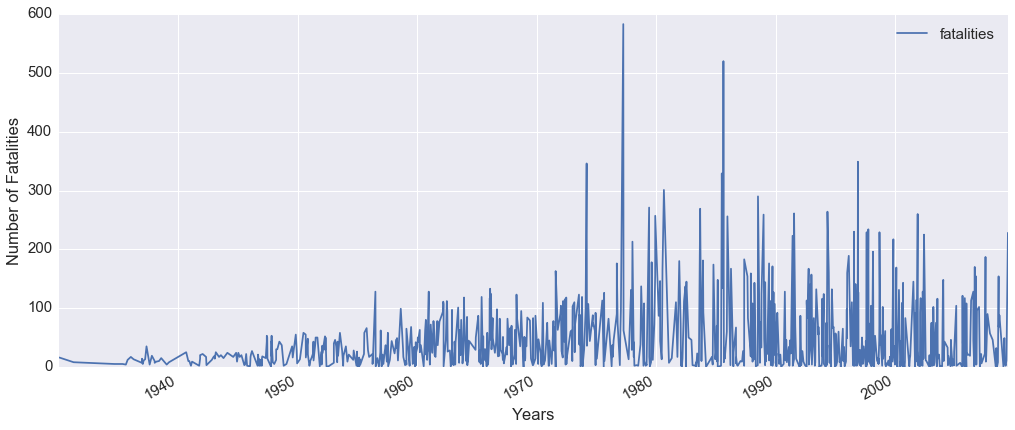

In [76]:
df_ts.fatalities.plot(legend=True, figsize=(17,7))
ylabel("Number of Fatalities")
xlabel("Years");

Travelling by airplane was not very popular until the 1960, where the number of fatalities start to increase as more commercial routes are opened and flying becomes more available to the public.

We can see spikes during the 1970's and late 1980's. Let's explore more those decades:

In [77]:
df_ts_70_80 = df_ts[(df_ts['year'] >= 1970) & (df_ts['year'] <= 1990)]

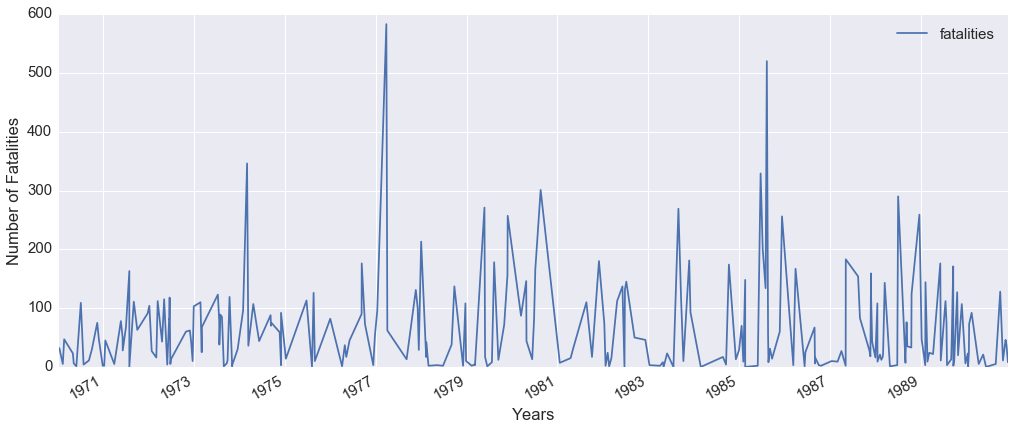

In [78]:
df_ts_70_80.fatalities.plot(legend=True, figsize=(17,7))
ylabel("Number of Fatalities")
xlabel("Years");

It seems we have important air disasters around 1974, 1977 and 1986.

In [79]:
df_ts_70_80[df_ts_70_80['year'] == 1974].fatalities

date
1974-01-30     96.0
1974-03-03    346.0
1974-03-13     36.0
1974-04-22    107.0
1974-06-08     44.0
1974-09-08     88.0
1974-09-11     70.0
1974-09-15     75.0
1974-11-20     59.0
1974-12-01      3.0
1974-12-01     92.0
Name: fatalities, dtype: float64

On `1974-03-03` we had a flight with 346 fatalities.

In [80]:
df_ts_70_80[df_ts_70_80['date'] == '1974-03-03']

,date,year,month,dayofweek,hour,time,location,operator,flight#,route,type,registration,cn/in,aboard,fatalities,ground,summary,time_seq
date,,,,,,,,,,,,,,,,,,
1974-03-03,1974-03-03,1974,3,6,11,11:41,"Near Ermenonville, France",Turkish Airlines (THY),981,Paris - London,McDonnell Douglas DC-10-10,TC-JAV,46704/29,346.0,346.0,0.0,The aircraft crashed shortly after takeoff fro...,420


In [81]:
df_ts_70_80[df_ts_70_80['year'] == 1977].fatalities

date
1977-01-13     96.0
1977-03-27    583.0
1977-04-04     62.0
1977-09-06     13.0
1977-11-19    131.0
1977-12-04    100.0
1977-12-13     29.0
Name: fatalities, dtype: float64

In [82]:
df_ts_70_80[df_ts_70_80['date'] == '1977-03-27']

,date,year,month,dayofweek,hour,time,location,operator,flight#,route,type,registration,cn/in,aboard,fatalities,ground,summary,time_seq
date,,,,,,,,,,,,,,,,,,
1977-03-27,1977-03-27,1977,3,6,17,17:07,"Tenerife, Canary Islands",Pan American World Airways / KLM,1736/4805,Tenerife - Las Palmas / Tenerife - Las Palmas,Boeing B-747-121 / Boeing B-747-206B,N736PA/PH-BUF,19643/11 / 20400/157,644.0,583.0,0.0,Both aircraft were diverted to Tenerife becaus...,446


The data for the above fatality is so far the worse air accident recorded in history.

In [83]:
df_ts_70_80[df_ts_70_80['year'] == 1985].fatalities

date
1985-01-01     29.0
1985-01-21     70.0
1985-02-04      9.0
1985-02-19    148.0
1985-02-19      0.0
1985-05-31      2.0
1985-06-23    329.0
1985-07-10    200.0
1985-08-02    134.0
1985-08-12    520.0
1985-08-22     55.0
1985-08-25      8.0
1985-09-06     31.0
1985-09-23     14.0
1985-11-24     60.0
1985-12-12    256.0
Name: fatalities, dtype: float64

In [84]:
df_ts_70_80[df_ts_70_80['date'] == '1985-08-12']

,date,year,month,dayofweek,hour,time,location,operator,flight#,route,type,registration,cn/in,aboard,fatalities,ground,summary,time_seq
date,,,,,,,,,,,,,,,,,,
1985-08-12,1985-08-12,1985,8,0,18,18:56,"Mt. Osutaka, near Ueno Village, Japan",Japan Air Lines,123,Tokyo - Osaka,Boeing B-747-SR46,JA8119,20783/230,524.0,520.0,0.0,The aircraft suffered an aft pressure bulkhead...,525


Above is the second worst commercial air flight in history.

Using `resample`, we will creating a plot of superimposing our data with seasonal and yearly averages:

In [85]:
seasonal_average = df_ts.resample('Q-NOV').mean()
yearly_average = df_ts.resample('A-NOV').mean()

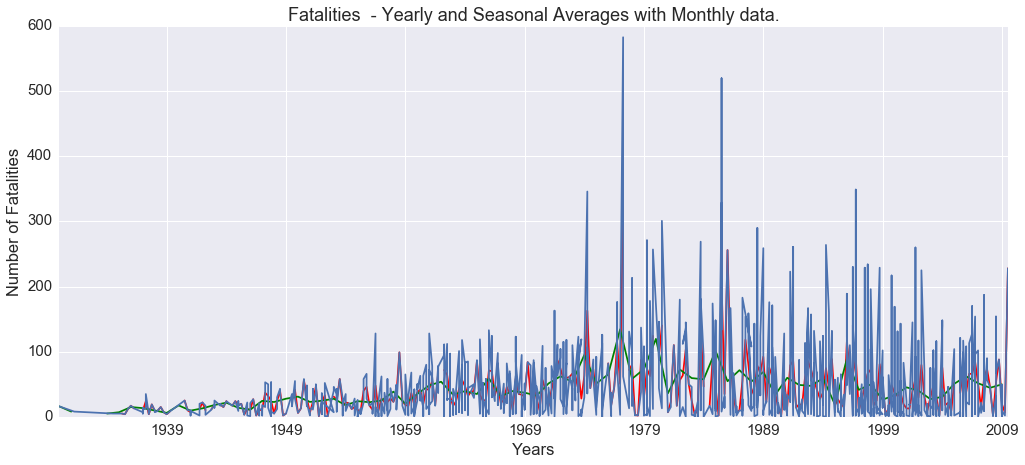

In [86]:
seasonal_average.fatalities.plot(legend=False, color='red', figsize=(17,7))
yearly_average.fatalities.plot(legend=False, color='green', figsize=(17,7))
df_ts.fatalities.plot(legend=False, figsize=(17,7))
title("Fatalities  - Yearly and Seasonal Averages with Monthly data.")
ylabel("Number of Fatalities")
xlabel("Years");

#### ETS

We will use time series regression methods to fit a model (OLS) to try fit the overall trend with increasing polynomial terms.

In [87]:
df_ets = df_ts.copy()
df_ets['time_seq_2'] = df_ts['time_seq']**2
df_ets['time_seq_3'] = df_ts['time_seq']**3
df_ets['time_seq_4'] = df_ts['time_seq']**4
df_ets['time_seq_5'] = df_ts['time_seq']**5
df_ets['time_seq_6'] = df_ts['time_seq']**6
df_ets['time_seq_7'] = df_ts['time_seq']**7

#### Model with up to 7th power:

In [88]:
X_7 = df_ets[['time_seq','time_seq_2','time_seq_3','time_seq_4','time_seq_5','time_seq_6','time_seq_7']]
X_7 = sm.add_constant(X_7)
y_7 = df_ets['fatalities']

model_7 = sm.OLS(y_7, X_7)
results_7 = model_7.fit()
results_7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             fatalities   R-squared:                       0.055
Model:                            OLS   Adj. R-squared:                  0.051
Method:                 Least Squares   F-statistic:                     13.73
Date:                Sun, 16 Oct 2016   Prob (F-statistic):           6.94e-11
Time:                        11:11:11   Log-Likelihood:                -5165.0
No. Observations:                 944   AIC:                         1.034e+04
Df Residuals:                     939   BIC:                         1.036e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       8.614e-13   1.28e-13      6.705      0.000    6.09e-13    1.11e-12
time_seq    4.422e-11    6.6e-12      6.705      0.000    3.13e-11    5.72e-11
time_seq_2  3.936e-08   5.87e-09      6.705      0.000    2.78e-08    5.09e-08
time_seq_3   5.41e-06   8.07e-07      6.705      0.000    3.83e-06    6.99e-06
time_seq_4 -1.758e-08   3.55e-09     -4.957      0.000   -2.45e-08   -1.06e-08
time_seq_5  1.927e-11   5.02e-12      3.841      0.000    9.42e-12    2.91e-11
time_seq_6 -7.049e-15   2.31e-15     -3.047      0.002   -1.16e-14   -2.51e-15
time_seq_7  1.497e-21   6.91e-19      0.002      0.998   -1.35e-18    1.36e-18
==============================================================================
Omnibus:                      566.166   Durbin-Watson:                   1.885
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7412.647
Skew:                           2.506   Prob(JB):                         0.00
Kurtosis:                      15.781   Cond. No.                     6.77e+19
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.77e+19. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The coefficient of `time_seq_7` is not significant as its p-value is higher than 0.05 (we fail to reject the null hypothesis).

#### Model with 6th power:

In [89]:
X_6 = df_ets[['time_seq','time_seq_2','time_seq_3','time_seq_4','time_seq_5','time_seq_6']]
X_6 = sm.add_constant(X_6)
y_6 = df_ets['fatalities']

model_6 = sm.OLS(y_6, X_6)
results_6 = model_6.fit()
results_6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             fatalities   R-squared:                       0.065
Model:                            OLS   Adj. R-squared:                  0.061
Method:                 Least Squares   F-statistic:                     16.32
Date:                Sun, 16 Oct 2016   Prob (F-statistic):           6.24e-13
Time:                        11:11:11   Log-Likelihood:                -5160.1
No. Observations:                 944   AIC:                         1.033e+04
Df Residuals:                     939   BIC:                         1.035e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.862e-07   5.95e-08      3.129      0.002    6.94e-08    3.03e-07
time_seq    2.366e-05   7.56e-06      3.129      0.002    8.82e-06    3.85e-05
time_seq_2     0.0018      0.001      3.129      0.002       0.001       0.003
time_seq_3 -7.614e-06   4.22e-06     -1.803      0.072   -1.59e-05    6.72e-07
time_seq_4  1.493e-08   1.08e-08      1.377      0.169   -6.35e-09    3.62e-08
time_seq_5 -1.514e-11   1.19e-11     -1.276      0.202   -3.84e-11    8.15e-12
time_seq_6  6.106e-15   4.69e-15      1.301      0.194   -3.11e-15    1.53e-14
==============================================================================
Omnibus:                      599.892   Durbin-Watson:                   1.905
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8680.217
Skew:                           2.676   Prob(JB):                         0.00
Kurtosis:                      16.858   Cond. No.                     2.79e+18
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.79e+18. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

More coefficients are not significant due to their high p-value: all terms starting with `time_seq_3`.

#### Model up to 5th power:

In [90]:
X_5 = df_ets[['time_seq','time_seq_2','time_seq_3','time_seq_4','time_seq_5']]
X_5 = sm.add_constant(X_5)
y_5 = df_ets['fatalities']

model_5 = sm.OLS(y_5, X_5)
results_5 = model_5.fit()
results_5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             fatalities   R-squared:                       0.071
Model:                            OLS   Adj. R-squared:                  0.067
Method:                 Least Squares   F-statistic:                     17.96
Date:                Sun, 16 Oct 2016   Prob (F-statistic):           3.21e-14
Time:                        11:11:11   Log-Likelihood:                -5157.1
No. Observations:                 944   AIC:                         1.032e+04
Df Residuals:                     939   BIC:                         1.035e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0062      0.002      2.798      0.005       0.002       0.011
time_seq       0.3344      0.119      2.798      0.005       0.100       0.569
time_seq_2    -0.0017      0.001     -1.601      0.110      -0.004       0.000
time_seq_3  5.721e-06   3.16e-06      1.812      0.070   -4.75e-07    1.19e-05
time_seq_4 -8.464e-09   3.93e-09     -2.154      0.032   -1.62e-08   -7.51e-10
time_seq_5  4.201e-12   1.73e-12      2.435      0.015    8.15e-13    7.59e-12
==============================================================================
Omnibus:                      611.334   Durbin-Watson:                   1.917
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9089.984
Skew:                           2.738   Prob(JB):                         0.00
Kurtosis:                      17.181   Cond. No.                     1.37e+15
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.37e+15. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Model with up to 4th power:

In [91]:
X_4 = df_ets[['time_seq','time_seq_2','time_seq_3','time_seq_4']]
X_4 = sm.add_constant(X_4)
y_4 = df_ets['fatalities']

model_4 = sm.OLS(y_4, X_4)
results_4 = model_4.fit()
results_4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             fatalities   R-squared:                       0.070
Model:                            OLS   Adj. R-squared:                  0.066
Method:                 Least Squares   F-statistic:                     17.59
Date:                Sun, 16 Oct 2016   Prob (F-statistic):           6.22e-14
Time:                        11:11:11   Log-Likelihood:                -5157.7
No. Observations:                 944   AIC:                         1.033e+04
Df Residuals:                     939   BIC:                         1.035e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         20.0243      9.376      2.136      0.033       1.624      38.425
time_seq      -0.1588      0.137     -1.157      0.248      -0.428       0.111
time_seq_2     0.0016      0.001      2.758      0.006       0.000       0.003
time_seq_3 -3.105e-06   9.39e-07     -3.308      0.001   -4.95e-06   -1.26e-06
time_seq_4  1.693e-09   4.93e-10      3.435      0.001    7.25e-10    2.66e-09
==============================================================================
Omnibus:                      615.930   Durbin-Watson:                   1.914
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9148.863
Skew:                           2.768   Prob(JB):                         0.00
Kurtosis:                      17.211   Cond. No.                     1.34e+12
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.34e+12. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Model with up to 2nd power:

In [92]:
X_2 = df_ets[['time_seq','time_seq_2']]
X_2 = sm.add_constant(X_2)
y_2 = df_ets['fatalities']

model_2 = sm.OLS(y_2, X_2)
results_2 = model_2.fit()
results_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             fatalities   R-squared:                       0.057
Model:                            OLS   Adj. R-squared:                  0.055
Method:                 Least Squares   F-statistic:                     28.65
Date:                Sun, 16 Oct 2016   Prob (F-statistic):           8.36e-13
Time:                        11:11:11   Log-Likelihood:                -5164.0
No. Observations:                 944   AIC:                         1.033e+04
Df Residuals:                     941   BIC:                         1.035e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.5707      5.633      0.811      0.417      -6.484      15.625
time_seq       0.1999      0.028      7.260      0.000       0.146       0.254
time_seq_2    -0.0002   2.82e-05     -6.494      0.000      -0.000      -0.000
==============================================================================
Omnibus:                      625.399   Durbin-Watson:                   1.889
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9550.416
Skew:                           2.818   Prob(JB):                         0.00
Kurtosis:                      17.527   Cond. No.                     1.20e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.2e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

We are choosing the "best" model based on adjusted $R^2$, which corresponds to the polynomial of 5th degree. We should be looking at AIC/BIC too, but the numbers seem to be too big (and theoretically should go up as we remove polynomials).

The p-value associated to the F-statistic is extremely low (3.21e-14), and all coefficients are significant (less than 0.05), except `time_seq_2`.

We will plot superimpose fitted data with original data for the 5th degree polynomial model:

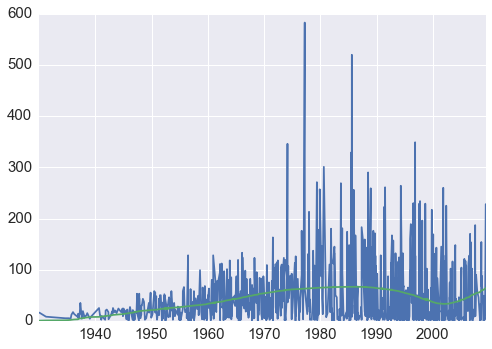

In [93]:
plt.plot(df_ts['date'],df_ts['fatalities'])
plt.plot(df_ets['date'],results_5.fittedvalues);

It follows the trend of data, but not a perfect fit.

In [94]:
df_ets['time_seq'].tail()

date
2009-02-12    940
2009-02-25    941
2009-03-23    942
2009-04-17    943
2009-06-01    944
Name: time_seq, dtype: int64

Let's make a prediction for right after `2009-06-01`. Next time on `time_seq` would be 945.

In [95]:
time_seq = 945
print("Predicted number of fatalities after 2009-06-01: ", str(results_5.predict([1,time_seq,time_seq**2,time_seq**3,time_seq**4,time_seq**5])[0]) + ".")

Predicted number of fatalities after 2009-06-01:  64.4109165071.


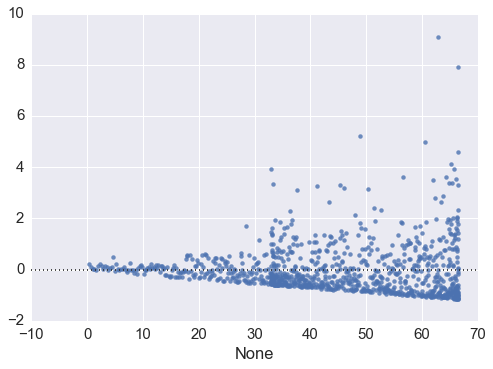

In [96]:
sns.residplot(results_5.fittedvalues, results_5.resid_pearson, df_ets);

The above residuals plot shows a relationship, not a good result.

#### ACF/PACF

Let's plot the autorrelation function (ACF):

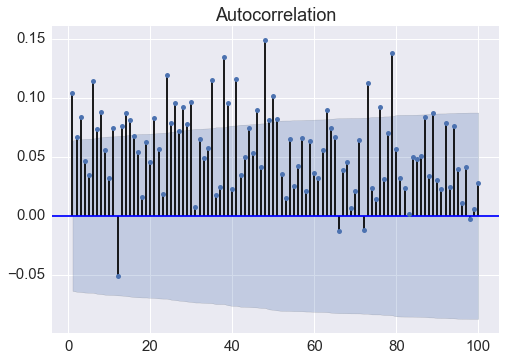

In [97]:
plot_acf(df_ts['fatalities'], lags=100, zero=False);

The above plot gives a strong indication of non-stationary, which is not a good thing: it means that the mean $\mu$ is not the same for all $t$. In general, a stationary time series will have no predictable patterns in the long-term.

Non-stationary can be addressed by transformation (which we have addressed before using log transformation, etc. and quite didn't work as we attempted before), etc. With non-stationary data we shouldn't build a model.

Let's plot now the autocorrelation function (PACF):

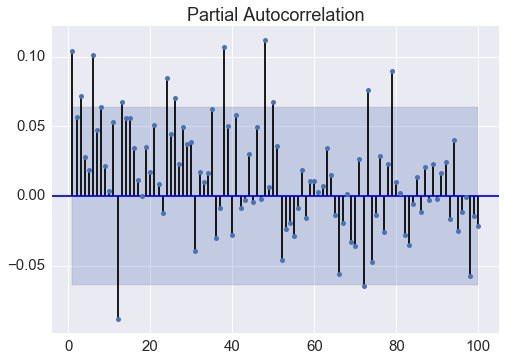

In [98]:
plot_pacf(df_ts['fatalities'], lags=100, zero=False);

The PACF plot above also gives indication of non-stationary.

https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/

Below we will show the non-stationary nature of the time series:

In [99]:
# We calculate the mean and standard deviation for our time series.
rolling_mean = pd.rolling_mean(df_ts.fatalities, window=12)
rolling_std = pd.rolling_std(df_ts.fatalities, window=12)

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,window=12).mean()
  from ipykernel import kernelapp as app
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:3: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,window=12).std()
  app.launch_new_instance()


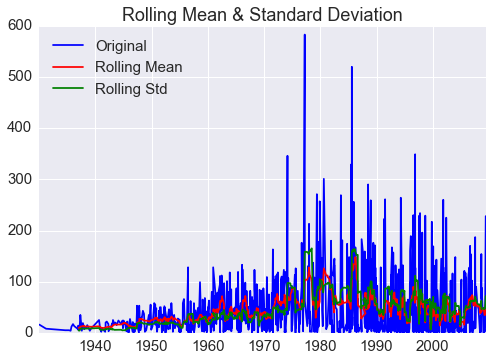

In [100]:
# Then we plot them all.
original_data = plt.plot(df_ts.fatalities, color='blue',label='Original')
mean = plt.plot(rolling_mean, color='red', label='Rolling Mean')
std = plt.plot(rolling_std, color='green', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show();

Mean and standard deviation are **not constant** in the time series.

#### AR/MA/ARMA/ARIMA.

Let's build some models using the ARIMA method.

ARIMA has three order arguments: the first one **p**, is for **AR**, the second one **d**, is for **I**, the third one **q**, is for **MA**.

If **q = 0**, we have a **AR** model. We set **d = 0**.

If **p = 0**, we have a **MA** model. We set **d = 0**.

If **p $\neq$ 0**, **q $\neq$ 0** and **d = 0**, we have a **ARMA** model.

If **p $\neq$ 0**, **d $\neq$ 0** and **q $\neq$ 0**, we have an **ARIMA** model.

#### AR model:

In [101]:
# ARIMA needs to have the variable set to FLOAT.
model_ar = sm.tsa.ARIMA(df_ts['fatalities'].astype(float), order=[2,0,0])
model_ar.fit().summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                           Results: ARMA
====================================================================
Model:              ARMA             BIC:                 10397.6281
Dependent Variable: fatalities       Log-Likelihood:      -5185.1   
Date:               2016-10-16 11:11 Scale:               1.0000    
No. Observations:   944              Method:              css-mle   
Df Model:           3                Sample:              01-19-1930
Df Residuals:       941                                   06-01-2009
Converged:          1.0000           S.D. of innovations: 58.777    
AIC:                10378.2276       HQIC:                10385.622 
--------------------------------------------------------------------
                      Coef.  Std.Err.    t    P>|t|   [0.025  0.975]
--------------------------------------------------------------------
const                44.5242   2.2668 19.6419 0.0000 40.0813 48.9670
ar.L1.fatalities      0.0992   0.0327  3.0382 0.0024  0.0352  0.1632
ar.L2.fatalities      0.0571   0.0326  1.7480 0.0808 -0.0069  0.1211
-----------------------------------------------------------------------------
                 Real           Imaginary          Modulus          Frequency
-----------------------------------------------------------------------------
AR.1            3.4061             0.0000           3.4061             0.0000
AR.2           -5.1444             0.0000           5.1444             0.5000
====================================================================

"""

The p-value of `ar.L2.fatalities` is greater than 0.05, therefore we fail to reject the null hypothesis and conclude that the coefficient for `ar.L2.fatalities` is not signigicant. Less try a new AR model with `p = 1`.

In [102]:
model_ar = sm.tsa.ARIMA(df_ts['fatalities'].astype(float), order=[1,0,0])
model_ar.fit().summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                           Results: ARMA
====================================================================
Model:              ARMA             BIC:                 10393.8284
Dependent Variable: fatalities       Log-Likelihood:      -5186.6   
Date:               2016-10-16 11:11 Scale:               1.0000    
No. Observations:   944              Method:              css-mle   
Df Model:           2                Sample:              01-19-1930
Df Residuals:       942                                   06-01-2009
Converged:          1.0000           S.D. of innovations: 58.873    
AIC:                10379.2781       HQIC:                10384.824 
--------------------------------------------------------------------
                      Coef.  Std.Err.    t    P>|t|   [0.025  0.975]
--------------------------------------------------------------------
const                44.5181   2.1414 20.7888 0.0000 40.3209 48.7152
ar.L1.fatalities      0.1053   0.0325  3.2386 0.0012  0.0416  0.1691
-----------------------------------------------------------------------------
                 Real           Imaginary          Modulus          Frequency
-----------------------------------------------------------------------------
AR.1            9.4949             0.0000           9.4949             0.0000
====================================================================

"""

The p-value associated to `ar.L1.fatalities` is less than 0.05, therefore we reject the null hypothesis and conclude that the coefficient of `ar.L1.fatalities` is significant. This AR model is better than the previous one.

#### MA model:

In [103]:
model_ma = sm.tsa.ARIMA(df_ts['fatalities'].astype(float), order=[0,0,2])
model_ma.fit().summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                           Results: ARMA
====================================================================
Model:              ARMA             BIC:                 10399.2313
Dependent Variable: fatalities       Log-Likelihood:      -5185.9   
Date:               2016-10-16 11:11 Scale:               1.0000    
No. Observations:   944              Method:              css-mle   
Df Model:           3                Sample:              01-19-1930
Df Residuals:       941                                   06-01-2009
Converged:          1.0000           S.D. of innovations: 58.827    
AIC:                10379.8308       HQIC:                10387.225 
--------------------------------------------------------------------
                      Coef.  Std.Err.    t    P>|t|   [0.025  0.975]
--------------------------------------------------------------------
const                44.5203   2.1884 20.3433 0.0000 40.2310 48.8095
ma.L1.fatalities      0.0931   0.0329  2.8317 0.0047  0.0287  0.1575
ma.L2.fatalities      0.0501   0.0319  1.5720 0.1163 -0.0124  0.1126
-----------------------------------------------------------------------------
                 Real           Imaginary          Modulus          Frequency
-----------------------------------------------------------------------------
MA.1           -0.9287            -4.3696           4.4672            -0.2833
MA.2           -0.9287             4.3696           4.4672             0.2833
====================================================================

"""

The p-value of `ma.L2.fatalities` is greater than 0.05, therefore we fail to reject the null hypothesis and conclude that the coefficient for `ma.L2.fatalities` is not signigicant. Less try a new MA model with q = 1.

In [104]:
model_ma = sm.tsa.ARIMA(df_ts['fatalities'].astype(float), order=[0,0,1])
model_ma.fit().summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                           Results: ARMA
====================================================================
Model:              ARMA             BIC:                 10394.8664
Dependent Variable: fatalities       Log-Likelihood:      -5187.2   
Date:               2016-10-16 11:11 Scale:               1.0000    
No. Observations:   944              Method:              css-mle   
Df Model:           2                Sample:              01-19-1930
Df Residuals:       942                                   06-01-2009
Converged:          1.0000           S.D. of innovations: 58.905    
AIC:                10380.3160       HQIC:                10385.862 
--------------------------------------------------------------------
                      Coef.  Std.Err.    t    P>|t|   [0.025  0.975]
--------------------------------------------------------------------
const                44.5148   2.1002 21.1959 0.0000 40.3986 48.6310
ma.L1.fatalities      0.0955   0.0312  3.0667 0.0022  0.0345  0.1566
-----------------------------------------------------------------------------
                Real            Imaginary          Modulus          Frequency
-----------------------------------------------------------------------------
MA.1          -10.4679             0.0000          10.4679             0.5000
====================================================================

"""

The p-value associated to `ma.L1.fatalities` is less than 0.05, therefore we reject the null hypothesis and conclude that the coefficient of `ma.L1.fatalities` is significant. This MA model is better than the previous one.

#### ARMA model:

In [105]:
model_arma = sm.tsa.ARIMA(df_ts['fatalities'].astype(float), order=[2,0,2])
model_arma.fit().summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                           Results: ARMA
====================================================================
Model:              ARMA             BIC:                 10372.3807
Dependent Variable: fatalities       Log-Likelihood:      -5165.6   
Date:               2016-10-16 11:11 Scale:               1.0000    
No. Observations:   944              Method:              css-mle   
Df Model:           5                Sample:              01-19-1930
Df Residuals:       939                                   06-01-2009
Converged:          1.0000           S.D. of innovations: 57.510    
AIC:                10343.2799       HQIC:                10354.371 
--------------------------------------------------------------------
                    Coef.  Std.Err.     t     P>|t|   [0.025  0.975]
--------------------------------------------------------------------
const              40.0313  11.1686    3.5843 0.0004 18.1412 61.9214
ar.L1.fatalities    0.0027   0.0057    0.4701 0.6384 -0.0084  0.0138
ar.L2.fatalities    0.9900   0.0056  175.9561 0.0000  0.9789  1.0010
ma.L1.fatalities    0.0257   0.0036    7.0785 0.0000  0.0186  0.0328
ma.L2.fatalities   -0.9743   0.0040 -244.7015 0.0000 -0.9821 -0.9665
-----------------------------------------------------------------------------
                 Real           Imaginary          Modulus          Frequency
-----------------------------------------------------------------------------
AR.1            1.0037             0.0000           1.0037             0.0000
AR.2           -1.0064             0.0000           1.0064             0.5000
MA.1           -1.0000             0.0000           1.0000             0.5000
MA.2            1.0264             0.0000           1.0264             0.0000
====================================================================

"""

Even though the p-value of `ar.L1.fatalities` is more than 0.05, we keep it in the model because `ar.L2.fatalities` has a p-value less than 0.05 (therefore we reject the null hypothesis and conclude that the coefficient of `ar.L2.fatalities` is significant), and specially because `ar.L2.fatalities` dependes on `ar.L1.fatalities` to build the model.

#### ARIMA

In [106]:
model_arima = sm.tsa.ARIMA(df_ts['fatalities'].astype(float), order=[2,1,2])
model_arima.fit().summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                           Results: ARIMA
====================================================================
Model:              ARIMA            BIC:                 10364.9307
Dependent Variable: D.fatalities     Log-Likelihood:      -5161.9   
Date:               2016-10-16 11:11 Scale:               1.0000    
No. Observations:   943              Method:              css-mle   
Df Model:           5                Sample:              03-31-1931
Df Residuals:       938                                   06-01-2009
Converged:          1.0000           S.D. of innovations: 57.590    
AIC:                10335.8363       HQIC:                10346.926 
--------------------------------------------------------------------
                      Coef.  Std.Err.    t    P>|t|   [0.025  0.975]
--------------------------------------------------------------------
const                 0.0367   0.0439  0.8352 0.4038 -0.0494  0.1227
ar.L1.D.fatalities   -0.8873   0.1625 -5.4617 0.0000 -1.2058 -0.5689
ar.L2.D.fatalities    0.0271   0.0350  0.7732 0.4396 -0.0416  0.0957
ma.L1.D.fatalities   -0.0557   0.1590 -0.3505 0.7261 -0.3673  0.2558
ma.L2.D.fatalities   -0.9030   0.1557 -5.7987 0.0000 -1.2082 -0.5978
-----------------------------------------------------------------------------
                 Real           Imaginary          Modulus          Frequency
-----------------------------------------------------------------------------
AR.1           -1.0907             0.0000           1.0907             0.5000
AR.2           33.8669             0.0000          33.8669             0.0000
MA.1            1.0220             0.0000           1.0220             0.0000
MA.2           -1.0837             0.0000           1.0837             0.5000
====================================================================

"""

The p-value of `ar.L2.D.fatalities` is higher than 0.05, therefore we fail to reject the null hypothesis and conclude that the coefficient of `ar.L2.D.fatalities` is not significant. 

However, even though the p-value of `ma.L1.D.fatalities` is higher than 0.05, we will keep in it the model because the p-value of `ma.L2.D.fatalities` has a p-value less than 0.05 and therefore we reject the null hypothesis and conclude that the coefficient of `ma.L2.D.fatalities` is significant: `ma.L2.D.fatalities` is calculated from `ma.L1.D.fatalities`.

Let's build a new ARIMA model with `q = 1`.

In [107]:
model_arima = sm.tsa.ARIMA(df_ts['fatalities'].astype(float), order=[2,1,1])
model_arima.fit().summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                           Results: ARIMA
====================================================================
Model:              ARIMA            BIC:                 10358.2183
Dependent Variable: D.fatalities     Log-Likelihood:      -5162.0   
Date:               2016-10-16 11:11 Scale:               1.0000    
No. Observations:   943              Method:              css-mle   
Df Model:           4                Sample:              03-31-1931
Df Residuals:       939                                   06-01-2009
Converged:          1.0000           S.D. of innovations: 57.594    
AIC:                10333.9730       HQIC:                10343.214 
--------------------------------------------------------------------
                    Coef.  Std.Err.     t     P>|t|   [0.025  0.975]
--------------------------------------------------------------------
const               0.0367   0.0440    0.8347 0.4041 -0.0495  0.1229
ar.L1.D.fatalities  0.0352   0.0333    1.0571 0.2907 -0.0300  0.1004
ar.L2.D.fatalities -0.0065   0.0332   -0.1967 0.8441 -0.0717  0.0586
ma.L1.D.fatalities -0.9784   0.0063 -156.3015 0.0000 -0.9907 -0.9661
-----------------------------------------------------------------------------
                 Real           Imaginary          Modulus          Frequency
-----------------------------------------------------------------------------
AR.1            2.6900           -12.0711          12.3672            -0.2151
AR.2            2.6900            12.0711          12.3672             0.2151
MA.1            1.0221             0.0000           1.0221             0.0000
====================================================================

"""

This model produces p-values for variables `ar.L1.D.fatalities` and `ar.L2.D.fatalities` greater than 0.05 and therefore we fail to reject the null hypothesis and conclude that the coefficients of the variables `ar.L1.D.fatalities` and `ar.L2.D.fatalities` are not significant.

However, the p-value of `ma.L1.D.fatalities` is less than 0.05, therefore we reject the null hypothesis and conclude that the coefficient of the variable `ma.L1.D.fatalities` is significant.

Let's try another ARIMA model with `p = 1`.

In [108]:
model_arima = sm.tsa.ARIMA(df_ts['fatalities'].astype(float), order=[1,1,1])
model_arima.fit().summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                           Results: ARIMA
====================================================================
Model:              ARIMA            BIC:                 10351.4079
Dependent Variable: D.fatalities     Log-Likelihood:      -5162.0   
Date:               2016-10-16 11:11 Scale:               1.0000    
No. Observations:   943              Method:              css-mle   
Df Model:           3                Sample:              03-31-1931
Df Residuals:       940                                   06-01-2009
Converged:          1.0000           S.D. of innovations: 57.596    
AIC:                10332.0116       HQIC:                10339.405 
--------------------------------------------------------------------
                    Coef.  Std.Err.     t     P>|t|   [0.025  0.975]
--------------------------------------------------------------------
const               0.0366   0.0439    0.8354 0.4037 -0.0493  0.1226
ar.L1.D.fatalities  0.0352   0.0333    1.0566 0.2910 -0.0301  0.1004
ma.L1.D.fatalities -0.9786   0.0061 -160.0626 0.0000 -0.9906 -0.9666
-----------------------------------------------------------------------------
                 Real           Imaginary          Modulus          Frequency
-----------------------------------------------------------------------------
AR.1           28.4436             0.0000          28.4436             0.0000
MA.1            1.0219             0.0000           1.0219             0.0000
====================================================================

"""

The p-value of `ar.L1.D.fatalities` is more than 0.05, therefore we fail to reject the null hypothesis and conclude that the coefficient of the variable `ar.L1.D.fatalities` is not significant.

The initial ARIMA model is the best one.

#### GLM

Since we have a process that should follow a Poisson model (aircraft fatalities), we will use GLM for Poisson data.

We will create a new column to specify a few types of aircraft manufacturers that we will use to build models:

In [109]:
df_ts['aircraft'] = df_ts['type'].apply(lambda x: 'Boeing' if x[:6] == 'Boeing' else 'Airbus' if x[:6] == 'Airbus' \
else 'Douglas' if x[:6] == 'Dougla' else 'Antonov' if x[:6] == 'Antono' else 'other')

In [110]:
len(df_ts.aircraft[(df_ts.aircraft == 'Boeing') | (df_ts.aircraft == 'Airbus') | (df_ts.aircraft == 'Douglas') | (df_ts.aircraft == 'Antonov')])

388

In [111]:
glm_model_1 = smf.glm('fatalities ~ aboard + year + ground', 
                    data=df_ts, 
                    offset=log(df_ts.aboard), 
                    family=family.Poisson()).fit()

glm_model_1.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
               Results: Generalized linear model
===============================================================
Model:              GLM              AIC:            23723.7329
Link Function:      log              BIC:            12820.1059
Dependent Variable: fatalities       Log-Likelihood: -11858.   
Date:               2016-10-16 11:11 LL-Null:        -12094.   
No. Observations:   944              Deviance:       19259.    
Df Model:           3                Pearson chi2:   1.32e+04  
Df Residuals:       940              Scale:          1.0000    
Method:             IRLS                                       
----------------------------------------------------------------
            Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
----------------------------------------------------------------
Intercept   3.1376    0.6051    5.1855  0.0000   1.9517   4.3235
aboard     -0.0009    0.0000  -17.3708  0.0000  -0.0010  -0.0008
year       -0.0017    0.0003   -5.5473  0.0000  -0.0023  -0.0011
ground      0.0001    0.0000    4.4755  0.0000   0.0001   0.0002
===============================================================

"""

The 1st GLM model has all predictive varibles coefficients with p-values less than 0.05, therefore we reject the null hypothesis and conclude that they are significant.

In [112]:
df_ts[(df_ts.aircraft == 'Antonov') & (df_ts.operator.str.contains('^Aeroflot'))]

,date,year,month,dayofweek,hour,time,location,operator,flight#,route,type,registration,cn/in,aboard,fatalities,ground,summary,time_seq,aircraft
date,,,,,,,,,,,,,,,,,,,
1976-09-09,1976-09-09,1976,9,3,14,14:50,"Off Adler, Russia",Aeroflot / Aeroflot,7957 /31,Donetsk - Sochi /Rostov na Donu - Kerch,Antonov AN-24 / Yakovlev Yak-40,46518/87772,37308504 / 9030713,90.0,90.0,0.0,Midair collision at FL187. ATC error. Fifty-t...,440,Antonov
1996-10-08,1996-10-08,1996,10,1,10,10:50,"San Francesco al Campo, Italy",Aeroflot,9981,"Moscow - Turin, Italy",Antonov An-124,RA-82069,9773053359122,23.0,2.0,0.0,The cargo plane struck trees and a house while...,701,Antonov


In [113]:
glm_model_2 = smf.glm('fatalities ~ aboard + year + ground + operator.str.contains("^Aeroflot") + aircraft == "Antonov"', 
                    data=df_ts, 
                    #offset=log(df_ts.aboard), 
                    family=family.Poisson()).fit()

glm_model_2.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                             Results: Generalized linear model
===========================================================================================
Model:                        GLM                       AIC:                     35015.2748
Link Function:                log                       BIC:                     24121.3480
Dependent Variable:           fatalities                Log-Likelihood:          -17502.   
Date:                         2016-10-16 11:11          LL-Null:                 -29516.   
No. Observations:             944                       Deviance:                30547.    
Df Model:                     5                         Pearson chi2:            2.63e+04  
Df Residuals:                 938                       Scale:                   1.0000    
Method:                       IRLS                                                         
-------------------------------------------------------------------------------------------
                                            Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-------------------------------------------------------------------------------------------
Intercept                                  -3.6531   0.5589  -6.5366 0.0000 -4.7485 -2.5577
operator.str.contains("^Aeroflot")[T.True]  0.7586   0.0274  27.6951 0.0000  0.7049  0.8123
aircraft == "Antonov"[T.True]              -0.2733   0.0471  -5.7958 0.0000 -0.3657 -0.1809
aboard                                      0.0063   0.0000 184.2812 0.0000  0.0062  0.0063
year                                        0.0035   0.0003  12.2844 0.0000  0.0029  0.0040
ground                                      0.0002   0.0000   7.7103 0.0000  0.0002  0.0003
===========================================================================================

"""

In [114]:
glm_model_3 = smf.glm('fatalities ~ aboard + year + ground + aircraft == "Antonov"', 
                    data=df_ts, 
                    offset=log(df_ts.aboard), 
                    family=family.Poisson()).fit()

glm_model_3.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                      Results: Generalized linear model
==============================================================================
Model:                   GLM                   AIC:                 23719.7836
Link Function:           log                   BIC:                 12821.0066
Dependent Variable:      fatalities            Log-Likelihood:      -11855.   
Date:                    2016-10-16 11:11      LL-Null:             -12094.   
No. Observations:        944                   Deviance:            19253.    
Df Model:                4                     Pearson chi2:        1.32e+04  
Df Residuals:            939                   Scale:               1.0000    
Method:                  IRLS                                                 
------------------------------------------------------------------------------
                               Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
------------------------------------------------------------------------------
Intercept                      3.2947   0.6086   5.4140 0.0000  2.1020  4.4874
aircraft == "Antonov"[T.True]  0.1165   0.0469   2.4837 0.0130  0.0246  0.2084
aboard                        -0.0009   0.0001 -16.9966 0.0000 -0.0010 -0.0008
year                          -0.0018   0.0003  -5.7769 0.0000 -0.0024 -0.0012
ground                         0.0001   0.0000   4.5216 0.0000  0.0001  0.0002
==============================================================================

"""

In [115]:
glm_model_4 = smf.glm('fatalities ~ aboard + year + ground + route', 
                    data=df_ts,
                    family=family.Poisson()).fit()

In [116]:
print("AIC: ", glm_model_4.aic ,".")
print("BIC: ", glm_model_4.bic,".")
print("Log-Likelihood: ", glm_model_4.llf,".") 
print("Total coefficient p-values: ", len(glm_model_4.pvalues),".") 
print("Total significant p-values: ", len(glm_model_4.pvalues[glm_model_4.pvalues < 0.05]),".") 

AIC:  6984.15231126 .
BIC:  489.287532067 .
Log-Likelihood:  -2579.07615563 .
Total coefficient p-values:  913 .
Total significant p-values:  458 .


In [117]:
glm_model_5 = smf.glm('fatalities ~ aboard + year + location + type', 
                    data=df_ts, 
                    offset=log(df_ts.aboard), 
                    family=family.Poisson()).fit()

In [118]:
print("AIC: ", glm_model_5.aic ,".")
print("BIC: ", glm_model_5.bic,".")
print("Log-Likelihood: ", glm_model_5.llf,".") 
print("Total coefficient p-values: ", len(glm_model_5.pvalues),".") 
print("Total significant p-values: ", len(glm_model_5.pvalues[glm_model_5.pvalues < 0.05]),".") 

AIC:  6344.50945314 .
BIC:  -1.13134961179e-07 .
Log-Likelihood:  -2228.25472657 .
Total coefficient p-values:  1471 .
Total significant p-values:  8 .


In [119]:
glm_model_5.pvalues[glm_model_5.pvalues < 0.05]

location[T.Accra, Ghana]                                0.015411
location[T.Mehamn, Norway]                              0.001471
location[T.Mt. Saint-Odile, near Strasbourg, France]    0.040283
location[T.Near Tucumcari, Arazona]                     0.001982
location[T.Pensacola, Florida]                          0.011666
location[T.Tegucigalpa, Honduras]                       0.002742
location[T.Windsor Locks, Connecticut]                  0.040454
type[T.Convair CV-340/440]                              0.040454
dtype: float64

In [172]:
glm_model_6 = smf.glm('fatalities ~ aboard + year + location + route', 
                    data=df_ts, 
                    #offset=log(df_ts.aboard), 
                    family=family.Poisson()).fit()

In [173]:
print("AIC: ", glm_model_6.aic ,".")
print("BIC: ", glm_model_6.bic,".")
print("Log-Likelihood: ", glm_model_6.llf,".") 
print("Total coefficient p-values: ", len(glm_model_6.pvalues),".") 
print("Total significant p-values: ", len(glm_model_6.pvalues[glm_model_6.pvalues < 0.05]),".") 

AIC:  4.3972187843e+59 .
BIC:  -3028178.34596 .
Log-Likelihood:  -2.19860939215e+59 .
Total coefficient p-values:  1761 .
Total significant p-values:  1761 .


In [120]:
def calc_one_glm(formula, item):
    glm_model = smf.glm(formula, 
                    data=df_ts, 
                    offset=log(df_ts.aboard), 
                    family=family.Poisson()).fit()
    
    summary = "AIC: " +  str(glm_model.aic) + " | BIC: " + str(glm_model.bic) + " | Log-Likelihood: " + str(glm_model.llf) + " | Total coefficient p-values: " +  str(len(glm_model.pvalues)) + " | Total significant p-values: " + str(len(glm_model.pvalues[glm_model.pvalues < 0.05]))
    return summary

In [121]:
item = "Accra, Ghana"
formula = 'fatalities ~ aboard + location == "' + item + '"'
calc_one_glm(formula, item)

'AIC: 23725.6332433 | BIC: 12817.1560669 | Log-Likelihood: -11859.8166216 | Total coefficient p-values: 3 | Total significant p-values: 3'

In [122]:
item = "Boeing"
formula = 'fatalities ~ aboard + aircraft == "' + item + '"'
calc_one_glm(formula, item)

'AIC: 23724.0798423 | BIC: 12815.6026659 | Log-Likelihood: -11859.0399212 | Total coefficient p-values: 3 | Total significant p-values: 3'

In [123]:
item = "Douglas"
formula = 'fatalities ~ aboard + aircraft == "' + item + '"'
calc_one_glm(formula, item)

'AIC: 23762.4040602 | BIC: 12853.9268838 | Log-Likelihood: -11878.2020301 | Total coefficient p-values: 3 | Total significant p-values: 3'

In [124]:
item = "Antonov"
formula = 'fatalities ~ aboard + aircraft == "' + item + '"'
calc_one_glm(formula, item)

'AIC: 23763.7238747 | BIC: 12855.2466983 | Log-Likelihood: -11878.8619373 | Total coefficient p-values: 3 | Total significant p-values: 2'

In [125]:
item = "Douglas"
formula = 'fatalities ~ aboard + route + aircraft == "' + item + '"'
calc_one_glm(formula, item)

'AIC: 6727.47423104 | BIC: 227.629941115 | Log-Likelihood: -2451.73711552 | Total coefficient p-values: 912 | Total significant p-values: 220'

In [126]:
item = "Douglas"
formula = 'fatalities ~ aboard + location + aircraft == "' + item + '"'
calc_one_glm(formula, item)

'AIC: 8235.15057253 | BIC: 1444.39812457 | Log-Likelihood: -3265.57528626 | Total coefficient p-values: 852 | Total significant p-values: 241'

In [127]:
item = "Douglas"
formula = 'fatalities ~ aboard + route + location + aircraft == "' + item + '"'
calc_one_glm(formula, item)

'AIC: 6342.73517191 | BIC: -6.77168169011 | Log-Likelihood: -2228.36758595 | Total coefficient p-values: 1761 | Total significant p-values: 564'

In [128]:
item = "Douglas"
formula = 'fatalities ~ aboard + operator == "United Air Lines" + aircraft == "' + item + '"'
calc_one_glm(formula, item)

'AIC: 23470.6636511 | BIC: 12567.0366009 | Log-Likelihood: -11731.3318256 | Total coefficient p-values: 4 | Total significant p-values: 4'

In [129]:
item = "Douglas"
formula = 'fatalities ~ aboard + year + aircraft == "' + item + '"'
calc_one_glm(formula, item)

'AIC: 23741.5825458 | BIC: 12837.9554955 | Log-Likelihood: -11866.7912729 | Total coefficient p-values: 4 | Total significant p-values: 3'

In [130]:
item = "Over the PacifiOcean"
formula = 'fatalities ~ aboard + aircraft + location == "' + item + '"'
calc_one_glm(formula, item)

'AIC: 23195.6042758 | BIC: 12306.5276041 | Log-Likelihood: -11590.8021379 | Total coefficient p-values: 7 | Total significant p-values: 7'

In [131]:
def calc_glm(formula, item, df, column):
    model_results = []

    glm_model = smf.glm(formula, 
                    data=df_ts, 
                    offset=log(df_ts.aboard), 
                    family=family.Poisson()).fit()
    
    model_results.append(glm_model.aic)
    model_results.append(glm_model.bic)
    model_results.append(glm_model.llf)
    model_results.append(len(glm_model.pvalues))
    model_results.append(len(glm_model.pvalues[glm_model.pvalues < 0.05]))
    
    #summary = "AIC: " +  str(glm_model.aic) + " | BIC: " + str(glm_model.bic) + " | Log-Likelihood: " + str(glm_model.llf) + " | Total coefficient p-values: " +  str(len(glm_model.pvalues)) + " | Total significant p-values: " + str(len(glm_model.pvalues[glm_model.pvalues < 0.05]))
    return model_results

In [132]:
df = df_ts
column = df.location
glm_results = []
for x in range(len(df_ts.location)):
    item = df_ts.location[x]
    formula = 'fatalities ~ aboard + location == "' + item + '"'
    glm_results.append(calc_glm(formula, item, df, column))
    
glm_results_array = np.asarray(glm_results)

Column 0 of the array has `AIC` values.

Column 1 of the array has `BIC` values.

Column 2 of the array has `LLF` values.

Column 3 of the array has `quantity of p-values` values.

Column 4 of the array has `quantity of significant p-values` values.

We want to find the min `AIC`, min `BIC`, max `LLF`, and max `quantity of significant p-values`.

In [133]:
min_aic = glm_results_array.min(axis=0)[0]
min_bic = glm_results_array.min(axis=0)[1]
max_llf = glm_results_array.max(axis=0)[2]
max_p_values = glm_results_array.max(axis=0)[3]
max_significant_p_values = glm_results_array.max(axis=0)[4]
min_aic, min_bic, max_llf, max_p_values, max_significant_p_values

(23289.61762070081, 12381.140444275135, -11641.808810350405, 3.0, 3.0)

In [134]:
np.where(glm_results_array == max_llf)

(array([158, 733]), array([2, 2]))

In [135]:
glm_results_array[158][2]

-11641.808810350405

In [136]:
df_ts.location[158]

'Over the PacifiOcean'

In [137]:
df = df_ts
column = df.operator
glm_results = []
for x in range(len(df_ts.operator)):
    item = df_ts.location[x]
    formula = 'fatalities ~ aboard + aircraft == "Douglas" + operator == "' + item + '"'
    glm_results.append(calc_glm(formula, item, df, column))
    
glm_results_array = np.asarray(glm_results)

In [138]:
min_aic = glm_results_array.min(axis=0)[0]
min_bic = glm_results_array.min(axis=0)[1]
max_llf = glm_results_array.max(axis=0)[2]
max_p_values = glm_results_array.max(axis=0)[3]
max_significant_p_values = glm_results_array.max(axis=0)[4]
min_aic, min_bic, max_llf, max_p_values, max_significant_p_values

(23762.404060183835, 12853.926883762908, -11878.202030091918, 4.0, 3.0)

THE ROUTE IS THE MOST RELEVANT.

In [139]:
df_ts[df_ts.aircraft=='Douglas']

,date,year,month,dayofweek,hour,time,location,operator,flight#,route,type,registration,cn/in,aboard,fatalities,ground,summary,time_seq,aircraft
date,,,,,,,,,,,,,,,,,,,
1935-05-06,1935-05-06,1935,5,0,03,03:30,"Atlanta, Missouri",Trans Continental and Western Air,6,Los Angeles - Albuquerque - Kanasas City - Wa...,Douglas DC-2-112,NC13785,1295,14.0,5.0,0.0,The plane crashed while en route from Albuquer...,4,Douglas
1936-01-14,1936-01-14,1936,1,1,19,19:32,"Goodwin, Arkansas",American Airlines,1,"Newark, NJ - Fort Worth, TX",Douglas DC-2-120,NC14274,1307,17.0,17.0,0.0,Flew into trees and disintegrated. The cause o...,7,Douglas
1936-04-07,1936-04-07,1936,4,1,10,10:20,"Uniontown, Pennsylvania",Trans Continental and Western Air,1,Newark - Los Angeles,Douglas DC-2-112,NC13721,1247,15.0,13.0,0.0,Crashed into Chestnut Ridge in fog. The poor ...,8,Douglas
1936-12-19,1936-12-19,1936,12,5,20,20:47,"Near Milford, Pennsylvania",Eastern Air Lines,14,"Miami, FL - Charleston, SC - Newark, NJ",Douglas DC-2-112,NC13732,1258,14.0,14.0,0.0,Crashed into trees in poor weather while attem...,10,Douglas
1937-02-09,1937-02-09,1937,2,1,20,20:50,"Off San Francisco, California",United Air Lines,23,Los Angeles - San Francisco - Oakland,Douglas DC-3A,NC16073,1913,11.0,11.0,0.0,"The aircraft crashed into San Francisco Bay, a...",13,Douglas
1937-03-25,1937-03-25,1937,3,3,18,18:40,"Clifton, Pennsylvania",Trans Continental and Western Air,15A,Newark - Camden - Pittsburg,Douglas DC-2-112,NC13730,1256,13.0,13.0,0.0,Crashed while attempting to land. Heavy icing ...,14,Douglas
1937-08-10,1937-08-10,1937,8,1,04,04:40,"Daytona Beach, Florida",Eastern Air Lines,7,Chicago - Daytona,Douglas DC-2,NC-13739,1289,9.0,4.0,0.0,The plane struck a power pole while taking off...,16,Douglas
1937-10-17,1937-10-17,1937,10,6,21,21:00,"Haydens Peak, Wyoming",United Air Lines,1,Cheyenne - Salt Lake City,Douglas DC-3,NC16074,1914,19.0,19.0,0.0,The plane crashed into the side of a mountain ...,17,Douglas
1938-03-01,1938-03-01,1938,3,1,21,21:30,"Near Wawona, Cailifornia",Trans Continental and Western Air,8,San Francisco - Burbank,Douglas DC-2-112,NC13789,1299,9.0,9.0,0.0,Crashed into the high Sierra after encounterin...,20,Douglas


In [209]:
item = "Over the PacifiOcean"
formula = 'fatalities ~ aboard + aircraft + time + location == "' + item + '"'
calc_one_glm(formula, item)

'AIC: 11395.8594705 | BIC: 3475.05964237 | Log-Likelihood: -5078.92973524 | Total coefficient p-values: 619 | Total significant p-values: 441'

In [210]:
item = "Over the PacifiOcean"
formula = 'fatalities ~ aboard + aircraft + location == "' + item + '"'
calc_one_glm(formula, item)

'AIC: 23195.6042758 | BIC: 12306.5276041 | Log-Likelihood: -11590.8021379 | Total coefficient p-values: 7 | Total significant p-values: 7'

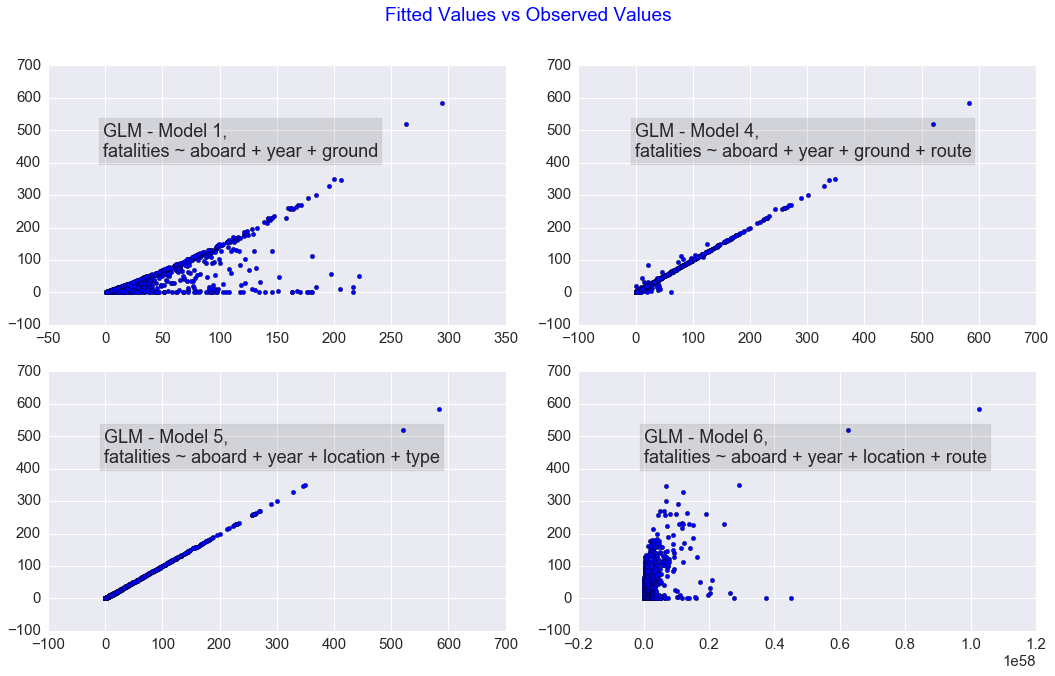

In [265]:
left = -1.8   #x coordinate for text insert

fig = plt.figure(figsize=(15,9))

ax = fig.add_subplot(2, 2, 1)
scatter(glm_model_1.fittedvalues, df_ts.fatalities)
top = ax.get_ylim()[1] * 0.75
txt = ax.text(left, top, "GLM - Model 1, \nfatalities ~ aboard + year + ground", verticalalignment='top')
txt.set_bbox(dict(facecolor='k', alpha=0.1))

ax = fig.add_subplot(2, 2, 2)
scatter(glm_model_4.fittedvalues, df_ts.fatalities)
top = ax.get_ylim()[1] * 0.75
txt = ax.text(left, top, "GLM - Model 4, \nfatalities ~ aboard + year + ground + route", verticalalignment='top')
txt.set_bbox(dict(facecolor='k', alpha=0.1))

ax = fig.add_subplot(2, 2, 3)
scatter(glm_model_5.fittedvalues, df_ts.fatalities)
ax.set_xlim(-100, 700)
top = ax.get_ylim()[1] * 0.75
txt = ax.text(left, top, "GLM - Model 5, \nfatalities ~ aboard + year + location + type", verticalalignment='top')
txt.set_bbox(dict(facecolor='k', alpha=0.1))

ax = fig.add_subplot(2, 2, 4)
scatter(glm_model_6.fittedvalues, df_ts.fatalities)
ax.set_xlim(-0.2*1e58, 1.2*1e58)
top = ax.get_ylim()[1] * 0.75
txt = ax.text(left, top, "GLM - Model 6, \nfatalities ~ aboard + year + location + route", verticalalignment='top')
txt.set_bbox(dict(facecolor='k', alpha=0.1))

fig.tight_layout()

plt.suptitle("Fitted Values vs Observed Values", x="0.5",y="1.05",size=19,color="blue")

plt.gcf();

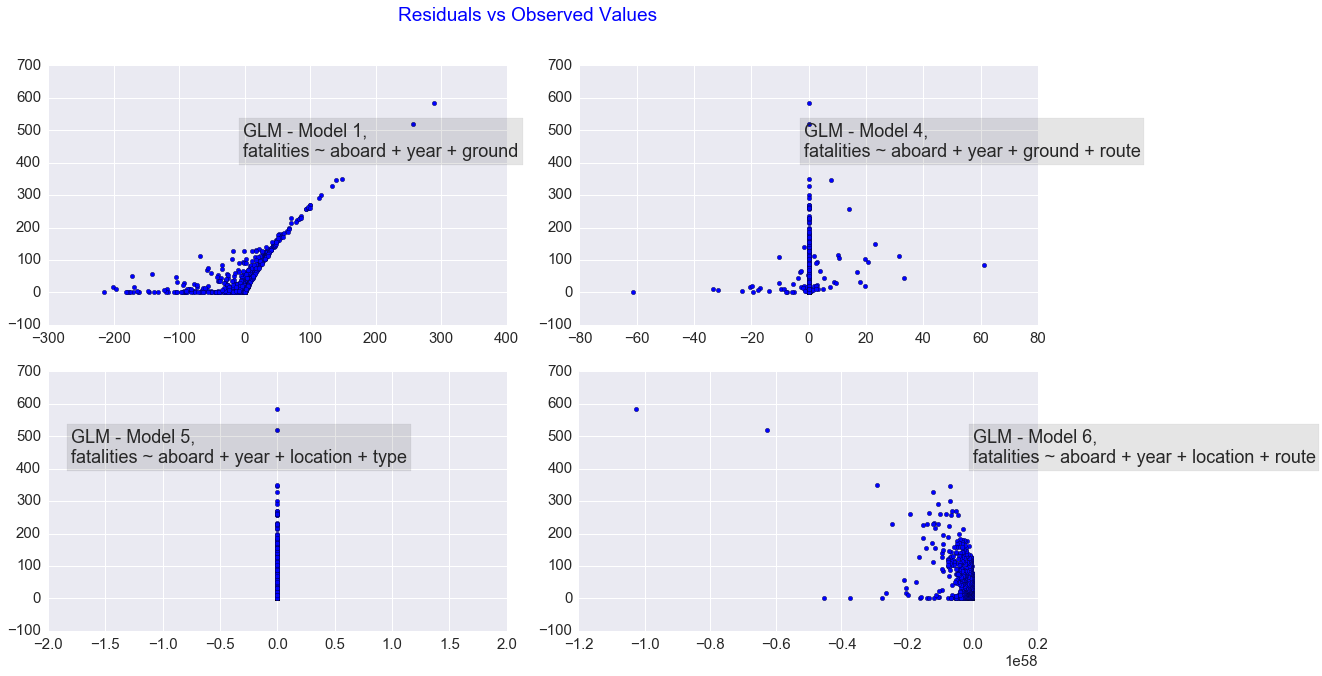

In [271]:
left = -1.8   #x coordinate for text insert

fig = plt.figure(figsize=(15,9))

ax = fig.add_subplot(2, 2, 1)
scatter(glm_model_1.resid_response, df_ts.fatalities)
top = ax.get_ylim()[1] * 0.75
txt = ax.text(left, top, "GLM - Model 1, \nfatalities ~ aboard + year + ground", verticalalignment='top')
txt.set_bbox(dict(facecolor='k', alpha=0.1))

ax = fig.add_subplot(2, 2, 2)
scatter(glm_model_4.resid_response, df_ts.fatalities)
top = ax.get_ylim()[1] * 0.75
txt = ax.text(left, top, "GLM - Model 4, \nfatalities ~ aboard + year + ground + route", verticalalignment='top')
txt.set_bbox(dict(facecolor='k', alpha=0.1))

ax = fig.add_subplot(2, 2, 3)
scatter(glm_model_5.resid_response, df_ts.fatalities)
ax.set_xlim(-2, 2)
top = ax.get_ylim()[1] * 0.75
txt = ax.text(left, top, "GLM - Model 5, \nfatalities ~ aboard + year + location + type", verticalalignment='top')
txt.set_bbox(dict(facecolor='k', alpha=0.1))

ax = fig.add_subplot(2, 2, 4)
scatter(glm_model_6.resid_response, df_ts.fatalities)
ax.set_xlim(-1.2*1e58, 0.2*1e58)
top = ax.get_ylim()[1] * 0.75
txt = ax.text(left, top, "GLM - Model 6, \nfatalities ~ aboard + year + location + route",
              verticalalignment='top')
txt.set_bbox(dict(facecolor='k', alpha=0.1))

fig.tight_layout()

plt.suptitle("Residuals vs Observed Values", x="0.5",y="1.05",size=19,color="blue")

plt.gcf();

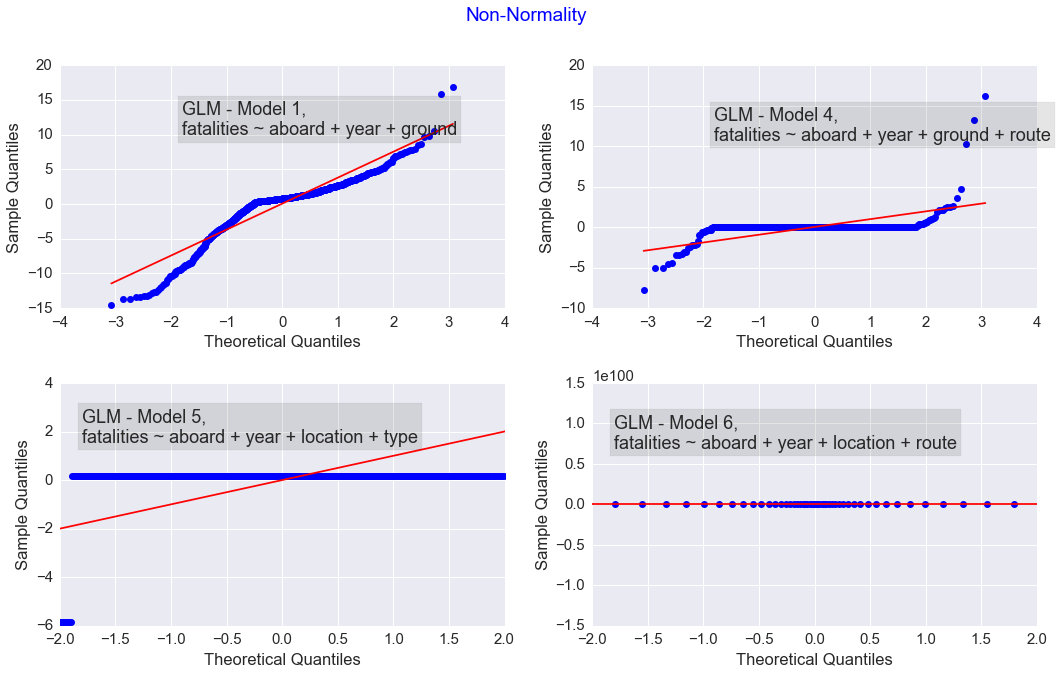

In [268]:
# http://statsmodels.sourceforge.net/devel/plots/graphics_gofplots_qqplot.py

left = -1.8   #x coordinate for text insert

fig = plt.figure(figsize=(15,9))

ax = fig.add_subplot(2, 2, 1)
sm.graphics.qqplot(glm_model_1.resid_pearson, line='s', ax=ax)
top = ax.get_ylim()[1] * 0.75
txt = ax.text(left, top, "GLM - Model 1, \nfatalities ~ aboard + year + ground", verticalalignment='top')
txt.set_bbox(dict(facecolor='k', alpha=0.1))

ax = fig.add_subplot(2, 2, 2)
sm.graphics.qqplot(glm_model_4.resid_pearson, line='s', ax=ax)
top = ax.get_ylim()[1] * 0.75
txt = ax.text(left, top, "GLM - Model 4, \nfatalities ~ aboard + year + ground + route", verticalalignment='top')
txt.set_bbox(dict(facecolor='k', alpha=0.1))

ax = fig.add_subplot(2, 2, 3)
sm.graphics.qqplot(glm_model_5.resid_pearson, line='45', fit=True, ax=ax)
ax.set_xlim(-2, 2)
top = ax.get_ylim()[1] * 0.75
txt = ax.text(left, top, "GLM - Model 5, \nfatalities ~ aboard + year + location + type", verticalalignment='top')
txt.set_bbox(dict(facecolor='k', alpha=0.1))

ax = fig.add_subplot(2, 2, 4)
sm.graphics.qqplot(glm_model_6.resid_pearson, dist=stats.t, line='45', fit=True, ax=ax)
ax.set_xlim(-2, 2)
top = ax.get_ylim()[1] * 0.75
txt = ax.text(left, top, "GLM - Model 6, \nfatalities ~ aboard + year + location + route", verticalalignment='top')
txt.set_bbox(dict(facecolor='k', alpha=0.1))

fig.tight_layout()

plt.suptitle("Non-Normality", x="0.5",y="1.05",size=19,color="blue")

plt.gcf();

The p-values of all variables is less than 0.05, therefore we reject the null hypothesis and conclude that the coefficients of the independent variables are significant.

In this model we can also see that the p-values of all coefficients are less than 0.05, therefore we reject the null hypothesis and conclude that the coefficients of the predictor variables are significant.

On comparing both models, the second one is better because:

* AIC/BIC are lower.
* Log-Likelihood is higher.

#### Analysis of Residuals

The above plot indicates non-Normality.

In [141]:
het_breushpagan(glm_model_2.resid_pearson, glm_model_2.model.exog) # the second output gives the p-value of the test

(569.02891926581765,
 5.2144512216824836e-123,
 475.49194377210392,
 6.6275285644507257e-188)

The p-value of 5.2144512216824836e-123 is less than 0.05, therefore we reject the null hypothesis of and conclude that data shows heteroskedasticity.

In [174]:
het_breushpagan(glm_model_5.resid_pearson, glm_model_5.model.exog) # the second output gives the p-value of the test

(944.0, 1.0, 0.0, nan)